# CODS626 Final Project: Swaps & Swaptions Analysis

## Core Research Question
**"Does the MOVE index help explain and predict short-horizon interest-rate risk (realized volatility of the 10Y swap rate) and the cost of convex protection (ATM swaption premium)?"**

---

### Notebook Structure:
- **Section A**: Data Pipeline (Yield Curve, MOVE, Swap Construction, Swaption Pricing)
- **Section B**: Data Quality & Missing Data
- **Section C**: Exploratory Data Analysis
- **Section D**: Outliers & Transforms
- **Section E**: ML Modeling (Time-Series Safe)
- **Section F**: Link to Swaption Pricing
- **Section G**: Deliverables
- **Section H**: Final Write-Up

In [24]:
# =============================================================================
# SETUP & IMPORTS
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import CubicSpline
from scipy.stats import norm
import matplotlib.pyplot as plt

# Statsmodels
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Scikit-learn
from sklearn.linear_model import HuberRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# For data fetching
import yfinance as yf
from datetime import datetime, timedelta
import os

# Set random seed for reproducibility
np.random.seed(42)

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Create output directories
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/plots', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/data', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/tables', exist_ok=True)

print("✓ All imports successful")
print(f"✓ Output directory: {OUTPUT_DIR}/")

✓ All imports successful
✓ Output directory: outputs/


---
# Section A: Data Pipeline (Reproducible)

## A.1 Yield Curve Data
- **Source**: Federal Reserve Board "Nominal Yield Curve" (SVENY series)
- **URL**: https://www.federalreserve.gov/data/nominal-yield-curve.htm
- **SVENYXX**: Zero-coupon yields, **continuously compounded**, in PERCENT
- Maturities: 1Y, 2Y, ..., 30Y (interpolated to 0.5Y grid for swap pricing)

## A.2 MOVE Index
- **Source**: yfinance ticker ^MOVE (ICE BofA MOVE Index)
- **Fallback**: Synthetic data if yfinance fails

## A.3 Curve & Swap Construction
- **Interpolate**: Cubic spline for SVENY yields to 0.5-year grid
- **Discount factors**: P(0,t) = exp(-(SVENY(t)/100) × t)
- **10Y Par Swap Rate**: S_t = (1 - P(0,10)) / A_t
- **Annuity Factor**: A_t = Σ Δ × P(0,t_i) with **Δ = 0.5** (semiannual fixed-leg accrual)

In [25]:
# =============================================================================
# A.1 FETCH YIELD CURVE DATA FROM FEDERAL RESERVE
# =============================================================================

def fetch_fed_yield_curve(start_date='2018-01-01', end_date=None):
    """
    Fetch Federal Reserve Nominal Yield Curve data (SVENY series).
    
    SVENYXX = Zero-coupon yields, continuously compounded, in PERCENT
    These are derived from the Svensson model fitted to Treasury prices.
    
    Source: https://www.federalreserve.gov/data/nominal-yield-curve.htm
    
    Returns:
    --------
    DataFrame with yields in PERCENT (not decimal) for proper discount factor calculation:
        P(0,t) = exp(-(SVENY(t)/100) * t)
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    # Fed yield curve data URL (CSV format)
    url = "https://www.federalreserve.gov/data/yield-curve-tables/feds200628.csv"
    
    try:
        # Read the CSV, skipping header rows
        df = pd.read_csv(url, skiprows=9)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date')
        
        # Select Svensson zero-coupon yields (SVENY columns)
        # SVENYXX: continuously compounded zero rates in PERCENT
        # SVENY01 = 1-year, SVENY02 = 2-year, ..., SVENY30 = 30-year
        sveny_cols = [col for col in df.columns if col.startswith('SVENY')]
        df_yields = df[sveny_cols].copy()
        
        # Rename columns to maturity in years
        rename_dict = {}
        for col in sveny_cols:
            maturity = int(col.replace('SVENY', ''))
            rename_dict[col] = maturity
        df_yields = df_yields.rename(columns=rename_dict)
        
        # Filter date range
        df_yields = df_yields.loc[start_date:end_date]
        
        # IMPORTANT: Keep yields in PERCENT for now
        # Will convert to decimal when computing discount factors: P(0,t) = exp(-(r/100)*t)
        # This avoids confusion about units
        
        print(f"✓ Fetched Fed SVENY (zero-coupon, continuously compounded) yields")
        print(f"  Observations: {len(df_yields)}")
        print(f"  Date range: {df_yields.index.min().date()} to {df_yields.index.max().date()}")
        print(f"  Maturities (years): {sorted(df_yields.columns.tolist())}")
        print(f"  Note: SVENY yields are in PERCENT (e.g., 4.5 = 4.5%)")
        print(f"  Sample 10Y yield: {df_yields[10].dropna().iloc[-1]:.4f}%")
        
        return df_yields
        
    except Exception as e:
        print(f"✗ Error fetching Fed yield curve: {e}")
        print("  Using fallback: generating synthetic yield curve data")
        return generate_synthetic_yield_curve(start_date, end_date)


def generate_synthetic_yield_curve(start_date, end_date):
    """
    Fallback: Generate synthetic yield curve data for demonstration.
    Returns yields in PERCENT to match SVENY format.
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    maturities = [1, 2, 3, 5, 7, 10, 20, 30]
    
    # Base yields in PERCENT (typical term structure)
    base_yields = {1: 2.0, 2: 2.5, 3: 2.8, 5: 3.2, 7: 3.5, 10: 3.8, 20: 4.2, 30: 4.5}
    
    data = {}
    np.random.seed(42)
    
    for mat in maturities:
        # Random walk with mean reversion (in percent)
        yields = [base_yields[mat]]
        for _ in range(len(dates) - 1):
            shock = np.random.normal(0, 0.1)  # 10 bps std dev
            mean_rev = 0.01 * (base_yields[mat] - yields[-1])
            yields.append(max(0.1, yields[-1] + shock + mean_rev))  # Floor at 0.1%
        data[mat] = yields
    
    df = pd.DataFrame(data, index=dates)
    print(f"✓ Generated synthetic yield curve: {len(df)} observations")
    print(f"  Note: Yields are in PERCENT (e.g., 4.0 = 4.0%)")
    return df


# Fetch yield curve data
START_DATE = '2018-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

yield_curve_df = fetch_fed_yield_curve(START_DATE, END_DATE)
yield_curve_df.head()

✗ Error fetching Fed yield curve: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1028)>
  Using fallback: generating synthetic yield curve data
✓ Generated synthetic yield curve: 2072 observations
  Note: Yields are in PERCENT (e.g., 4.0 = 4.0%)


,1,2,3,5,7,10,20,30
2018-01-01,2.000000,2.500000,2.800000,3.200000,3.500000,3.800000,4.200000,4.500000
2018-01-02,2.049671,2.623613,2.838131,3.069541,3.399592,4.057275,4.128403,4.731752
2018-01-03,2.035348,2.631243,2.868915,2.981486,3.495035,4.104685,4.137624,4.787775
2018-01-04,2.099764,2.649662,2.716335,2.819533,3.510250,3.902524,4.114302,4.852507
2018-01-05,2.251069,2.586400,2.454098,2.824560,3.407772,3.865376,4.087846,4.966272


In [26]:
# =============================================================================
# A.2 FETCH MOVE INDEX DATA
# =============================================================================

def fetch_move_index(start_date='2018-01-01', end_date=None):
    """
    Fetch MOVE Index (ICE BofA MOVE Index) from yfinance.
    MOVE measures implied volatility in the Treasury market.
    
    Ticker: ^MOVE
    """
    if end_date is None:
        end_date = datetime.now().strftime('%Y-%m-%d')
    
    try:
        # Try fetching from yfinance
        ticker = yf.Ticker("^MOVE")
        df = ticker.history(start=start_date, end=end_date)
        
        if len(df) == 0:
            raise ValueError("No data returned from yfinance")
        
        # Keep only Close price (this is the MOVE index value)
        move_df = df[['Close']].copy()
        move_df.columns = ['MOVE']
        move_df.index = pd.to_datetime(move_df.index.date)  # Remove timezone
        move_df.index.name = 'Date'
        
        print(f"✓ Fetched MOVE index from yfinance: {len(move_df)} observations")
        print(f"  Date range: {move_df.index.min().date()} to {move_df.index.max().date()}")
        print(f"  MOVE range: {move_df['MOVE'].min():.2f} to {move_df['MOVE'].max():.2f}")
        
        return move_df
        
    except Exception as e:
        print(f"✗ yfinance failed: {e}")
        print("  Using fallback: generating synthetic MOVE data")
        return generate_synthetic_move(start_date, end_date)


def generate_synthetic_move(start_date, end_date):
    """
    Fallback: Generate synthetic MOVE index data for demonstration.
    MOVE typically ranges from ~50 (low vol) to ~200+ (high vol, crisis).
    """
    dates = pd.date_range(start=start_date, end=end_date, freq='B')
    
    np.random.seed(42)
    
    # Start at typical level
    move = [80]
    for i in range(len(dates) - 1):
        # Mean-reverting with occasional spikes
        shock = np.random.normal(0, 3)
        mean_rev = 0.02 * (90 - move[-1])
        
        # Occasional vol spikes (like COVID, rate hike cycles)
        if np.random.random() < 0.01:
            shock += np.random.choice([30, -20])
        
        new_val = max(40, move[-1] + shock + mean_rev)  # Floor at 40
        move.append(new_val)
    
    df = pd.DataFrame({'MOVE': move}, index=dates)
    df.index.name = 'Date'
    
    print(f"✓ Generated synthetic MOVE index: {len(df)} observations")
    return df


# Fetch MOVE index
move_df = fetch_move_index(START_DATE, END_DATE)
move_df.head()

✓ Fetched MOVE index from yfinance: 1974 observations
  Date range: 2018-01-02 to 2025-12-08
  MOVE range: 36.62 to 182.64


,MOVE
Date,
2018-01-02,49.169998
2018-01-03,47.599998
2018-01-04,47.380001
2018-01-05,46.070000
2018-01-08,45.900002


In [27]:
# =============================================================================
# A.3 MERGE DATASETS & INTERPOLATE YIELD CURVE
# =============================================================================

def interpolate_zero_rates(yield_curve_df, target_maturities):
    """
    Interpolate SVENY zero rates to target maturities using cubic spline.
    
    Fed SVENY data starts at 1 year. For maturities < 1Y (e.g., 0.5Y),
    we use linear extrapolation from the short end of the curve.
    
    Parameters:
    -----------
    yield_curve_df : DataFrame with SVENY yields in PERCENT, maturities as columns
    target_maturities : list of target maturities in years (e.g., 0.5, 1.0, ..., 10.0)
    
    Returns:
    --------
    DataFrame with interpolated zero rates in PERCENT for target maturities
    """
    results = []
    
    for date in yield_curve_df.index:
        row = yield_curve_df.loc[date].dropna()
        mats = sorted([m for m in row.index if isinstance(m, (int, float))])
        
        if len(mats) < 4:
            # Not enough points for interpolation
            results.append({m: np.nan for m in target_maturities})
            continue
        
        # Cubic spline interpolation for interior points
        cs = CubicSpline(mats, row[mats].values)
        
        interp_rates = {}
        min_mat = min(mats)
        max_mat = max(mats)
        
        for t in target_maturities:
            if t >= min_mat and t <= max_mat:
                # Interior: use cubic spline
                interp_rates[t] = float(cs(t))
            elif t < min_mat:
                # Extrapolation for short maturities (< 1Y)
                # Linear extrapolation using slope at short end
                # r(t) ≈ r(1Y) - (1Y - t) * slope
                slope = cs(min_mat, 1)  # First derivative at min maturity
                interp_rates[t] = float(row[min_mat] + slope * (t - min_mat))
                # Floor at 0 to avoid negative rates in extrapolation
                interp_rates[t] = max(0.0, interp_rates[t])
            else:
                # Extrapolation beyond max maturity (use flat)
                interp_rates[t] = float(row[max_mat])
        
        results.append(interp_rates)
    
    interp_df = pd.DataFrame(results, index=yield_curve_df.index)
    return interp_df


def compute_discount_factors(zero_rates_pct_df):
    """
    Compute discount factors from SVENY zero rates.
    
    Formula: P(0,t) = exp(-(SVENY(t)/100) * t)
    
    SVENY yields are continuously compounded and expressed in PERCENT.
    
    Parameters:
    -----------
    zero_rates_pct_df : DataFrame with SVENY yields in PERCENT, maturities as columns
    
    Returns:
    --------
    DataFrame with discount factors P(0,t)
    """
    discount_df = pd.DataFrame(index=zero_rates_pct_df.index)
    
    for maturity in zero_rates_pct_df.columns:
        t = float(maturity)
        # Convert from percent to decimal: divide by 100
        # P(0,t) = exp(-(r_pct/100) * t)
        discount_df[f'P_{t}'] = np.exp(-(zero_rates_pct_df[maturity] / 100.0) * t)
    
    return discount_df


# Define maturities needed for swap (semiannual payments from 0.5 to 10 years)
SWAP_MATURITIES = [0.5 * i for i in range(1, 21)]  # 0.5, 1.0, ..., 10.0
print(f"Target maturities for 10Y swap (Δ=0.5): {SWAP_MATURITIES}")

# Interpolate zero rates (output in PERCENT)
print("\nInterpolating SVENY yields to 0.5-year grid...")
interp_rates_df = interpolate_zero_rates(yield_curve_df, SWAP_MATURITIES)
print(f"✓ Interpolated rates shape: {interp_rates_df.shape}")
print(f"  Sample interpolated rates (last date):")
print(f"    r(0.5Y) = {interp_rates_df[0.5].dropna().iloc[-1]:.4f}%")
print(f"    r(1.0Y) = {interp_rates_df[1.0].dropna().iloc[-1]:.4f}%")
print(f"    r(5.0Y) = {interp_rates_df[5.0].dropna().iloc[-1]:.4f}%")
print(f"    r(10.0Y) = {interp_rates_df[10.0].dropna().iloc[-1]:.4f}%")

# Compute discount factors: P(0,t) = exp(-(r_pct/100) * t)
print("\nComputing discount factors: P(0,t) = exp(-(SVENY(t)/100) × t)...")
discount_df = compute_discount_factors(interp_rates_df)
print(f"✓ Discount factors shape: {discount_df.shape}")
print(f"  Sample discount factors (last date):")
print(f"    P(0,0.5) = {discount_df['P_0.5'].dropna().iloc[-1]:.6f}")
print(f"    P(0,1.0) = {discount_df['P_1.0'].dropna().iloc[-1]:.6f}")
print(f"    P(0,5.0) = {discount_df['P_5.0'].dropna().iloc[-1]:.6f}")
print(f"    P(0,10.0) = {discount_df['P_10.0'].dropna().iloc[-1]:.6f}")

# Merge with MOVE index
print("\nMerging datasets...")
merged_df = discount_df.join(move_df, how='inner')
merged_df = merged_df.join(interp_rates_df.add_prefix('r_'), how='left')
print(f"✓ Merged dataset shape: {merged_df.shape}")
print(f"  Date range: {merged_df.index.min().date()} to {merged_df.index.max().date()}")

merged_df.head()

Target maturities for 10Y swap (Δ=0.5): [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0]

Interpolating SVENY yields to 0.5-year grid...
✓ Interpolated rates shape: (2072, 20)
  Sample interpolated rates (last date):
    r(0.5Y) = 1.1290%
    r(1.0Y) = 1.8940%
    r(5.0Y) = 3.0774%
    r(10.0Y) = 3.6087%

Computing discount factors: P(0,t) = exp(-(SVENY(t)/100) × t)...
✓ Discount factors shape: (2072, 20)
  Sample discount factors (last date):
    P(0,0.5) = 0.994371
    P(0,1.0) = 0.981238
    P(0,5.0) = 0.857384
    P(0,10.0) = 0.697070

Merging datasets...
✓ Merged dataset shape: (1974, 41)
  Date range: 2018-01-02 to 2025-12-08


,P_0.5,P_1.0,P_1.5,P_2.0,P_2.5,P_3.0,P_3.5,P_4.0,P_4.5,P_5.0,...,r_5.5,r_6.0,r_6.5,r_7.0,r_7.5,r_8.0,r_8.5,r_9.0,r_9.5,r_10.0
2018-01-02,0.991925,0.979712,0.964629,0.948881,0.933406,0.918380,0.903444,0.888449,0.873278,0.857720,...,3.136915,3.214314,3.301840,3.399592,3.506981,3.620653,3.736563,3.850667,3.958919,4.057275
2018-01-03,0.991931,0.979852,0.964808,0.948736,0.932754,0.917532,0.903297,0.889767,0.876211,0.861505,...,3.072778,3.200338,3.346859,3.495035,3.630591,3.751383,3.858300,3.952230,4.034063,4.104685
2018-01-04,0.991895,0.979221,0.963718,0.948386,0.934383,0.921742,0.909664,0.897403,0.884071,0.868510,...,2.961046,3.142218,3.334726,3.510250,3.646402,3.744533,3.811926,3.855866,3.883637,3.902524
2018-01-05,0.990928,0.977741,0.962745,0.949587,0.938832,0.929022,0.917496,0.903374,0.886781,0.868291,...,2.982288,3.135245,3.278663,3.407772,3.518965,3.613269,3.692874,3.759968,3.816739,3.865376
2018-01-08,0.990696,0.977994,0.963580,0.950204,0.938522,0.927844,0.916608,0.904037,0.889723,0.873338,...,2.853692,3.018425,3.187441,3.345335,3.479853,3.591343,3.683301,3.759226,3.822617,3.876971


In [28]:
# =============================================================================
# A.4 COMPUTE 10Y PAR SWAP RATE
# =============================================================================

def compute_swap_rate(discount_df, delta=0.5, swap_tenor=10):
    """
    Compute the par swap rate for a given tenor with semiannual fixed payments.
    
    Par swap rate formula:
        S_t = (1 - P(0,T)) / A_t
    
    where:
        A_t = Σ Δ × P(0,t_i) for t_i = Δ, 2Δ, ..., T (annuity factor)
        Δ = 0.5 (semiannual fixed-leg accrual)
        T = swap tenor (10 years)
    
    For a 10Y swap with semiannual payments:
        - 20 payment dates: t_i = 0.5, 1.0, 1.5, ..., 10.0
        - A_t = 0.5 × [P(0,0.5) + P(0,1.0) + ... + P(0,10.0)]
        - With typical rates (~4%), A_t ≈ 0.5 × 17 ≈ 8.5
    
    Parameters:
    -----------
    discount_df : DataFrame with discount factors P_0.5, P_1.0, ..., P_10.0
    delta : fixed-leg accrual fraction (0.5 for semiannual)
    swap_tenor : swap maturity in years
    
    Returns:
    --------
    DataFrame with S_t (swap rate), A_t (annuity), P_T (terminal discount factor)
    """
    # Number of payments
    n_payments = int(swap_tenor / delta)
    
    # Payment dates: 0.5, 1.0, 1.5, ..., 10.0
    payment_dates = [delta * i for i in range(1, n_payments + 1)]
    
    print(f"  Swap tenor: {swap_tenor} years")
    print(f"  Payment frequency: semiannual (Δ = {delta})")
    print(f"  Number of payments: {n_payments}")
    print(f"  Payment dates: {payment_dates[0]}, {payment_dates[1]}, ..., {payment_dates[-1]}")
    
    # Get discount factor column names
    pv_cols = [f'P_{t}' for t in payment_dates]
    
    # Check which columns exist
    available_cols = [col for col in pv_cols if col in discount_df.columns]
    if len(available_cols) < len(pv_cols):
        missing = set(pv_cols) - set(available_cols)
        print(f"  ⚠️ Warning: Missing discount factors: {missing}")
    
    results = pd.DataFrame(index=discount_df.index)
    
    # Annuity factor: A_t = Σ Δ × P(0,t_i)
    # IMPORTANT: Δ = 0.5 for semiannual accrual
    annuity = pd.Series(0.0, index=discount_df.index)
    for col in available_cols:
        annuity += delta * discount_df[col]  # delta = 0.5
    results['A_t'] = annuity
    
    # Terminal discount factor P(0,T)
    terminal_col = f'P_{float(swap_tenor)}'
    if terminal_col in discount_df.columns:
        results['P_10'] = discount_df[terminal_col]
    else:
        # Try to find the closest
        for col in discount_df.columns:
            if '10.0' in col or col == 'P_10':
                results['P_10'] = discount_df[col]
                break
    
    # Par swap rate: S_t = (1 - P(0,T)) / A_t
    results['S_t'] = (1 - results['P_10']) / results['A_t']
    
    # Convert to percentage for readability
    results['S_t_pct'] = results['S_t'] * 100
    
    return results


# Compute swap rates with EXPLICIT delta = 0.5
print("Computing 10Y par swap rates with semiannual fixed payments...")
print("=" * 60)
DELTA = 0.5  # Semiannual accrual factor
SWAP_TENOR = 10  # 10-year swap

swap_df = compute_swap_rate(merged_df, delta=DELTA, swap_tenor=SWAP_TENOR)

# Merge with main dataset
merged_df = merged_df.join(swap_df)
print(f"\n✓ Added S_t (swap rate), A_t (annuity), P_10 (terminal DF)")

# VERIFICATION: Check annuity factor is reasonable
print(f"\n" + "=" * 60)
print("ANNUITY FACTOR VERIFICATION:")
print("=" * 60)
sample_A = swap_df['A_t'].dropna().iloc[-1]
sample_P10 = swap_df['P_10'].dropna().iloc[-1]
sample_S = swap_df['S_t'].dropna().iloc[-1]

print(f"  Sample date: {swap_df.index[-1].date()}")
print(f"  A_t = {sample_A:.6f}")
print(f"  P(0,10) = {sample_P10:.6f}")
print(f"  S_t = (1 - P_10) / A_t = (1 - {sample_P10:.6f}) / {sample_A:.6f} = {sample_S:.6f}")
print(f"  S_t = {sample_S * 100:.4f}%")

# Sanity check: A_t should be roughly 0.5 × sum of DFs
# With 20 payments and typical DFs around 0.85 average, A_t ≈ 0.5 × 20 × 0.85 ≈ 8.5
expected_A_approx = DELTA * 20 * 0.85
print(f"\n  Sanity check: With Δ={DELTA}, 20 payments, avg DF≈0.85:")
print(f"    Expected A_t ≈ {expected_A_approx:.1f}")
print(f"    Actual A_t = {sample_A:.4f}")
if 6 < sample_A < 10:
    print(f"    ✓ A_t is in reasonable range [6, 10]")
else:
    print(f"    ⚠️ A_t outside expected range - check calculations!")

# Display summary
print(f"\n10Y Par Swap Rate Summary:")
print(f"  Mean:   {swap_df['S_t_pct'].mean():.4f}%")
print(f"  Std:    {swap_df['S_t_pct'].std():.4f}%")
print(f"  Min:    {swap_df['S_t_pct'].min():.4f}%")
print(f"  Max:    {swap_df['S_t_pct'].max():.4f}%")

merged_df[['S_t', 'S_t_pct', 'A_t', 'P_10', 'MOVE']].tail(10)

Computing 10Y par swap rates with semiannual fixed payments...
  Swap tenor: 10 years
  Payment frequency: semiannual (Δ = 0.5)
  Number of payments: 20
  Payment dates: 0.5, 1.0, ..., 10.0

✓ Added S_t (swap rate), A_t (annuity), P_10 (terminal DF)

ANNUITY FACTOR VERIFICATION:
  Sample date: 2025-12-08
  A_t = 8.388514
  P(0,10) = 0.692939
  S_t = (1 - P_10) / A_t = (1 - 0.692939) / 8.388514 = 0.036605
  S_t = 3.6605%

  Sanity check: With Δ=0.5, 20 payments, avg DF≈0.85:
    Expected A_t ≈ 8.5
    Actual A_t = 8.3885
    ✓ A_t is in reasonable range [6, 10]

10Y Par Swap Rate Summary:
  Mean:   3.6298%
  Std:    0.5269%
  Min:    2.1385%
  Max:    4.8577%


,S_t,S_t_pct,A_t,P_10,MOVE
2025-11-24,0.038592,3.859193,8.422561,0.674957,76.820000
2025-11-25,0.038553,3.855254,8.401905,0.676085,72.820000
2025-11-26,0.038048,3.804780,8.415209,0.679820,71.900002
2025-11-28,0.039561,3.956051,8.339724,0.670076,68.949997
2025-12-01,0.039470,3.947025,8.326418,0.671354,71.349998
2025-12-02,0.038590,3.859023,8.346138,0.677921,69.910004
2025-12-03,0.037278,3.727762,8.356042,0.688507,66.459999
2025-12-04,0.036079,3.607928,8.400395,0.696920,65.690002
2025-12-05,0.036908,3.690791,8.377853,0.690791,67.279999
2025-12-08,0.036605,3.660488,8.388514,0.692939,72.300003


In [29]:
# =============================================================================
# A.5 SWAPTION PRICING (BACHELIER MODEL)
# =============================================================================

def bachelier_atm_price(notional, annuity, sigma_n, T):
    """
    Bachelier (Normal) model ATM payer swaption price.
    
    For ATM options (K = S), the formula simplifies to:
        V = N * A * σ_N * sqrt(T) * sqrt(2/π)
        
    where:
        N = notional
        A = annuity factor
        σ_N = normal volatility (in absolute terms, e.g., 0.01 = 100 bps)
        T = option maturity in years
    
    Note: sqrt(2/π) ≈ 0.7979
    """
    return notional * annuity * sigma_n * np.sqrt(T) * np.sqrt(2 / np.pi)


def bachelier_greeks(notional, annuity, sigma_n, T, S):
    """
    Bachelier model Greeks for ATM payer swaption.
    
    Returns:
    --------
    dict with:
        delta: dV/dS (per 1 unit change in swap rate)
        vega: dV/dσ_N (per 1 unit change in normal vol)
        gamma: d²V/dS² (second derivative)
        vega_per_bp: dV per 1bp change in normal vol
        vega_per_move_pt: dV per 1 MOVE point (approximation)
    """
    # For ATM Bachelier:
    # Delta = N * A * N(d) where d=0 for ATM, so Delta = N * A * 0.5
    delta = notional * annuity * 0.5
    
    # Vega = N * A * sqrt(T) * sqrt(2/π)
    vega = notional * annuity * np.sqrt(T) * np.sqrt(2 / np.pi)
    
    # Gamma = N * A * n(d) / (σ_N * sqrt(T)) where n(d)=1/sqrt(2π) for d=0
    # For ATM: Gamma = N * A / (σ_N * sqrt(T) * sqrt(2π))
    gamma = notional * annuity / (sigma_n * np.sqrt(T) * np.sqrt(2 * np.pi))
    
    # Vega per 1bp change in normal vol (1bp = 0.0001)
    vega_per_bp = vega * 0.0001
    
    # Vega per 1 MOVE point (MOVE/10000 = σ_N proxy)
    vega_per_move_pt = vega * (1 / 10000)
    
    return {
        'delta': delta,
        'vega': vega,
        'gamma': gamma,
        'vega_per_bp': vega_per_bp,
        'vega_per_move_pt': vega_per_move_pt
    }


def black76_atm_price(notional, annuity, sigma_ln, T, forward):
    """
    Black-76 (Lognormal) model ATM payer swaption price.
    
    For ATM options (K = F):
        V = N * A * F * [2*N(d) - 1] where d = σ*sqrt(T)/2
        
    Simplifies to approximately:
        V ≈ N * A * F * σ * sqrt(T) * sqrt(2/π)  (for small σ*sqrt(T))
    """
    d = sigma_ln * np.sqrt(T) / 2
    price = notional * annuity * forward * (2 * norm.cdf(d) - 1)
    return price


# =============================================================================
# PRICE DAILY SWAPTIONS
# =============================================================================

# Parameters
NOTIONAL = 1_000_000  # $1MM notional
OPTION_MATURITY = 1/12  # 1 month = 1/12 year

print("Pricing 1M ATM payer swaptions on 10Y swap...")

# Normal volatility proxy: σ_N = MOVE / 10000
# This converts MOVE (in bps equivalent) to decimal normal vol
merged_df['sigma_N'] = merged_df['MOVE'] / 10000

# Bachelier ATM price
merged_df['V_bachelier'] = bachelier_atm_price(
    NOTIONAL, 
    merged_df['A_t'], 
    merged_df['sigma_N'], 
    OPTION_MATURITY
)

# Black-76 ATM price (optional comparison)
# Lognormal vol ≈ Normal vol / Forward rate
merged_df['sigma_LN'] = merged_df['sigma_N'] / merged_df['S_t']
merged_df['V_black76'] = black76_atm_price(
    NOTIONAL,
    merged_df['A_t'],
    merged_df['sigma_LN'],
    OPTION_MATURITY,
    merged_df['S_t']
)

# Compute Greeks for each day
greeks_data = []
for idx in merged_df.index:
    row = merged_df.loc[idx]
    if pd.notna(row['sigma_N']) and pd.notna(row['A_t']) and row['sigma_N'] > 0:
        greeks = bachelier_greeks(NOTIONAL, row['A_t'], row['sigma_N'], OPTION_MATURITY, row['S_t'])
        greeks_data.append(greeks)
    else:
        greeks_data.append({k: np.nan for k in ['delta', 'vega', 'gamma', 'vega_per_bp', 'vega_per_move_pt']})

greeks_df = pd.DataFrame(greeks_data, index=merged_df.index)
merged_df = merged_df.join(greeks_df)

print(f"✓ Priced swaptions for {len(merged_df)} dates")
print(f"\nSwaption Price Summary (Bachelier):")
print(f"  Mean:   ${merged_df['V_bachelier'].mean():,.2f}")
print(f"  Std:    ${merged_df['V_bachelier'].std():,.2f}")
print(f"  Min:    ${merged_df['V_bachelier'].min():,.2f}")
print(f"  Max:    ${merged_df['V_bachelier'].max():,.2f}")

merged_df[['S_t_pct', 'MOVE', 'sigma_N', 'V_bachelier', 'V_black76', 'delta', 'vega_per_move_pt']].tail(10)

Pricing 1M ATM payer swaptions on 10Y swap...
✓ Priced swaptions for 1974 dates

Swaption Price Summary (Bachelier):
  Mean:   $16,379.41
  Std:    $5,915.95
  Min:    $7,123.77
  Max:    $35,474.09


,S_t_pct,MOVE,sigma_N,V_bachelier,V_black76,delta,vega_per_move_pt
2025-11-24,3.859193,76.820000,0.007682,14902.801877,7450.375883,4211280.725298,193.996380
2025-11-25,3.855254,72.820000,0.007282,14092.170636,7045.212543,4200952.647971,193.520608
2025-11-26,3.804780,71.900002,0.007190,13936.163619,6967.217894,4207604.421752,193.827028
2025-11-28,3.956051,68.949997,0.006895,13244.493716,6621.548438,4169861.940389,192.088387
2025-12-01,3.947025,71.349998,0.007135,13683.639050,6841.043308,4163208.939764,191.781911
2025-12-02,3.859023,69.910004,0.006991,13439.228712,6718.848704,4173069.194912,192.236132
2025-12-03,3.727762,66.459999,0.006646,12791.173321,6394.880881,4178021.000606,192.464242
2025-12-04,3.607928,65.690002,0.006569,12710.083894,6354.310532,4200197.431541,193.485819
2025-12-05,3.690791,67.279999,0.006728,12982.794163,6490.648165,4188926.715724,192.966623
2025-12-08,3.660488,72.300003,0.007230,13969.240174,6983.674076,4194256.966214,193.212166


In [30]:
# =============================================================================
# A.6 COMPUTE TARGET: REALIZED VOLATILITY (FORWARD-LOOKING)
# =============================================================================

def compute_realized_vol_forward(swap_rates, window=21, annualization_factor=252):
    """
    Compute forward-looking realized volatility of swap rate changes.
    
    IMPORTANT: This is a FORWARD-LOOKING target!
    At time t, realized_vol_t uses changes from t+1 to t+window.
    
    realized_vol_t = sqrt(252) * std(ΔS_{t+1}, ..., ΔS_{t+window})
    
    Parameters:
    -----------
    swap_rates : Series of daily swap rates
    window : number of trading days (21 ≈ 1 month)
    annualization_factor : 252 for daily data
    
    Returns:
    --------
    Series with forward-looking realized volatility
    """
    # Daily changes
    delta_S = swap_rates.diff()
    
    # Forward-looking rolling std
    # Shift the rolling calculation back to align with time t
    realized_vol = delta_S.rolling(window=window).std().shift(-window)
    
    # Annualize
    realized_vol = realized_vol * np.sqrt(annualization_factor)
    
    return realized_vol


# Compute realized volatility target
print("Computing forward-looking realized volatility target...")
print("  Window: 21 trading days (≈1 month)")
print("  Formula: realized_vol_t = sqrt(252) * std(ΔS_{t+1:t+21})")

merged_df['delta_S'] = merged_df['S_t'].diff()  # Daily change in swap rate
merged_df['realized_vol'] = compute_realized_vol_forward(merged_df['S_t'], window=21)

# Also compute lagged realized vol (useful as feature later)
merged_df['realized_vol_lag21'] = merged_df['realized_vol'].shift(21)

# Count valid observations
n_valid_target = merged_df['realized_vol'].notna().sum()
n_dropped = 21  # Last 21 days have no target

print(f"\n✓ Computed realized_vol target")
print(f"  Valid observations: {n_valid_target}")
print(f"  Dropped (no target): {n_dropped} (last 21 days)")

print(f"\nRealized Volatility Summary (annualized):")
print(f"  Mean:   {merged_df['realized_vol'].mean()*100:.4f}%")
print(f"  Std:    {merged_df['realized_vol'].std()*100:.4f}%")
print(f"  Min:    {merged_df['realized_vol'].min()*100:.4f}%")
print(f"  Max:    {merged_df['realized_vol'].max()*100:.4f}%")

# Verify no look-ahead bias
print(f"\n⚠️  LEAKAGE CHECK:")
print(f"  realized_vol uses FUTURE changes (t+1 to t+21)")
print(f"  Features at time t use only information available at t")
print(f"  Last {n_dropped} observations have NaN target (as expected)")

merged_df[['S_t', 'delta_S', 'realized_vol', 'MOVE', 'V_bachelier']].tail(25)

Computing forward-looking realized volatility target...
  Window: 21 trading days (≈1 month)
  Formula: realized_vol_t = sqrt(252) * std(ΔS_{t+1:t+21})

✓ Computed realized_vol target
  Valid observations: 1953
  Dropped (no target): 21 (last 21 days)

Realized Volatility Summary (annualized):
  Mean:   1.3907%
  Std:    0.2408%
  Min:    0.6767%
  Max:    2.0776%

⚠️  LEAKAGE CHECK:
  realized_vol uses FUTURE changes (t+1 to t+21)
  Features at time t use only information available at t
  Last 21 observations have NaN target (as expected)


,S_t,delta_S,realized_vol,MOVE,V_bachelier
2025-10-31,0.039334,-0.001099,0.015519,66.610001,12758.263181
2025-11-03,0.038937,-0.000397,0.015955,67.230003,12869.383585
2025-11-04,0.039685,0.000748,0.016014,68.019997,12973.678787
2025-11-05,0.040195,0.000509,0.015850,72.419998,13824.301425
2025-11-06,0.039972,-0.000223,NaN,72.440002,13842.375975
2025-11-07,0.040762,0.000790,NaN,74.410004,14128.312651
2025-11-10,0.038724,-0.002038,NaN,78.860001,15035.726282
2025-11-12,0.039484,0.000760,NaN,81.120003,15473.135844
2025-11-13,0.038603,-0.000881,NaN,79.099998,15161.339212
2025-11-14,0.038011,-0.000592,NaN,79.709999,15238.483606


---
# Section B: Data Quality & Missing Data

Report missingness and document handling decisions.

MISSING DATA REPORT

1. MISSING VALUES BY COLUMN:
----------------------------------------
  S_t                 :     0 ( 0.00%)
  A_t                 :     0 ( 0.00%)
  P_10                :     0 ( 0.00%)
  MOVE                :     0 ( 0.00%)
  sigma_N             :     0 ( 0.00%)
  V_bachelier         :     0 ( 0.00%)
  realized_vol        :    21 ( 1.06%)
  delta_S             :     1 ( 0.05%)

2. MISSING VALUES BY YEAR:
----------------------------------------
      S_t  A_t  P_10  MOVE  sigma_N  V_bachelier  realized_vol  delta_S
2018    0    0     0     0        0            0             0        1
2019    0    0     0     0        0            0             0        0
2020    0    0     0     0        0            0             0        0
2021    0    0     0     0        0            0             0        0
2022    0    0     0     0        0            0             0        0
2023    0    0     0     0        0            0             0        0
2024    0    0     0    

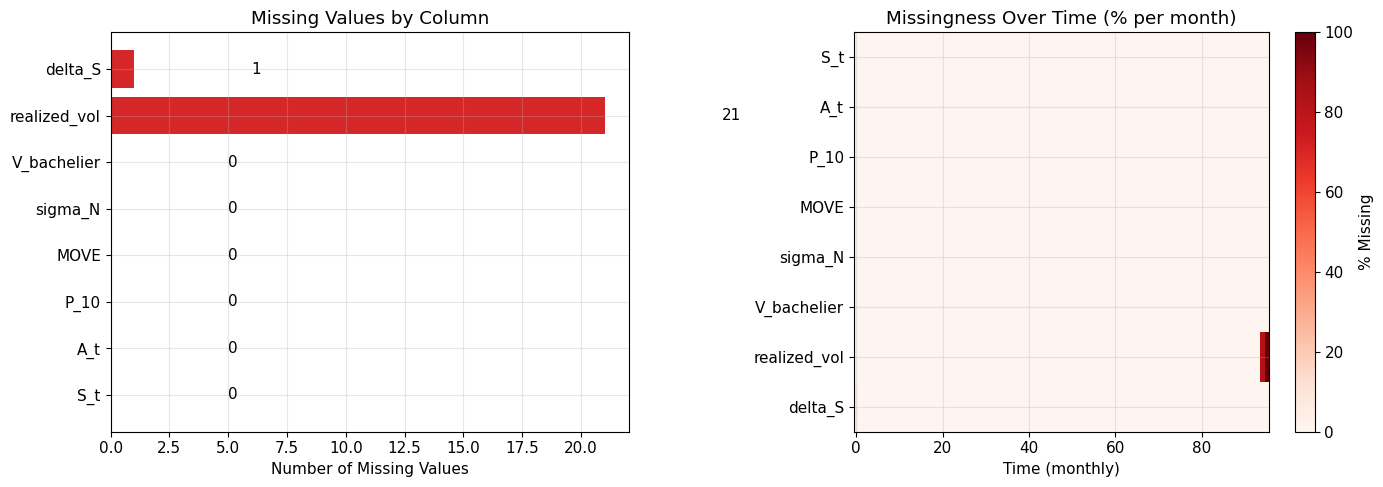


✓ Saved: outputs/plots/missing_data_report.png


In [31]:
# =============================================================================
# B.1 REPORT MISSINGNESS
# =============================================================================

# Key columns to analyze
key_cols = ['S_t', 'A_t', 'P_10', 'MOVE', 'sigma_N', 'V_bachelier', 'realized_vol', 'delta_S']

print("=" * 60)
print("MISSING DATA REPORT")
print("=" * 60)

# Missing by column
print("\n1. MISSING VALUES BY COLUMN:")
print("-" * 40)
for col in key_cols:
    if col in merged_df.columns:
        n_missing = merged_df[col].isna().sum()
        pct_missing = 100 * n_missing / len(merged_df)
        print(f"  {col:20s}: {n_missing:5d} ({pct_missing:5.2f}%)")

# Missing by time period
print("\n2. MISSING VALUES BY YEAR:")
print("-" * 40)
yearly_missing = merged_df[key_cols].isna().groupby(merged_df.index.year).sum()
print(yearly_missing)

# Create missingness heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of missing values
ax1 = axes[0]
missing_counts = merged_df[key_cols].isna().sum()
colors = ['#d62728' if x > 0 else '#2ca02c' for x in missing_counts]
ax1.barh(key_cols, missing_counts, color=colors)
ax1.set_xlabel('Number of Missing Values')
ax1.set_title('Missing Values by Column')
ax1.axvline(x=0, color='black', linewidth=0.5)
for i, v in enumerate(missing_counts):
    ax1.text(v + 5, i, str(v), va='center')

# Missingness over time (heatmap-style)
ax2 = axes[1]
# Sample monthly to reduce noise
monthly_missing = merged_df[key_cols].isna().resample('M').mean() * 100
im = ax2.imshow(monthly_missing.T.values, aspect='auto', cmap='Reds', vmin=0, vmax=100)
ax2.set_yticks(range(len(key_cols)))
ax2.set_yticklabels(key_cols)
ax2.set_xlabel('Time (monthly)')
ax2.set_title('Missingness Over Time (% per month)')
plt.colorbar(im, ax=ax2, label='% Missing')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/missing_data_report.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR}/plots/missing_data_report.png")

In [32]:
# =============================================================================
# B.2 HANDLE MISSING DATA
# =============================================================================

print("=" * 60)
print("MISSING DATA HANDLING DECISIONS")
print("=" * 60)

# Store original count
n_original = len(merged_df)

# Decision 1: MOVE missing values
n_move_missing = merged_df['MOVE'].isna().sum()
print(f"\n1. MOVE Index Missing: {n_move_missing} observations")
if n_move_missing > 0:
    if n_move_missing < 10:
        print("   Decision: Forward-fill (small number of gaps)")
        merged_df['MOVE'] = merged_df['MOVE'].ffill()
        merged_df['sigma_N'] = merged_df['MOVE'] / 10000
        print("   ✓ Applied forward-fill to MOVE")
    else:
        print("   Decision: Drop days with missing MOVE")
        merged_df = merged_df.dropna(subset=['MOVE'])
        print(f"   ✓ Dropped {n_move_missing} rows")
else:
    print("   No missing values - no action needed")

# Decision 2: Yield curve / swap rate missing
n_swap_missing = merged_df['S_t'].isna().sum()
print(f"\n2. Swap Rate (S_t) Missing: {n_swap_missing} observations")
if n_swap_missing > 0:
    print("   Decision: Drop days with missing curve data")
    merged_df = merged_df.dropna(subset=['S_t', 'A_t', 'P_10'])
    print(f"   ✓ Dropped rows with missing curve data")
else:
    print("   No missing values - no action needed")

# Decision 3: Realized vol (expected to have missing at end)
n_rv_missing = merged_df['realized_vol'].isna().sum()
print(f"\n3. Realized Vol Target Missing: {n_rv_missing} observations")
print("   Expected: Last 21 days have no forward-looking target")
print("   Decision: Keep NaN (will drop when creating modeling dataset)")

# Final dataset
n_final = len(merged_df)
print(f"\n" + "=" * 60)
print(f"FINAL DATASET:")
print(f"  Original:  {n_original} observations")
print(f"  Remaining: {n_final} observations")
print(f"  Dropped:   {n_original - n_final} ({100*(n_original-n_final)/n_original:.2f}%)")
print("=" * 60)

# Verify data quality
print("\n✓ Data Quality Checks:")
print(f"  - Index sorted: {merged_df.index.is_monotonic_increasing}")
print(f"  - Date range: {merged_df.index.min().date()} to {merged_df.index.max().date()}")
print(f"  - All S_t > 0: {(merged_df['S_t'] > 0).all()}")
print(f"  - All MOVE > 0: {(merged_df['MOVE'] > 0).all()}")

MISSING DATA HANDLING DECISIONS

1. MOVE Index Missing: 0 observations
   No missing values - no action needed

2. Swap Rate (S_t) Missing: 0 observations
   No missing values - no action needed

3. Realized Vol Target Missing: 21 observations
   Expected: Last 21 days have no forward-looking target
   Decision: Keep NaN (will drop when creating modeling dataset)

FINAL DATASET:
  Original:  1974 observations
  Remaining: 1974 observations
  Dropped:   0 (0.00%)

✓ Data Quality Checks:
  - Index sorted: True
  - Date range: 2018-01-02 to 2025-12-08
  - All S_t > 0: True
  - All MOVE > 0: True


---
# Section C: Exploratory Data Analysis (EDA)

1. Summary Statistics
2. Time-Series Plots
3. Scatter Plots
4. Correlation Analysis

In [33]:
# =============================================================================
# C.1 SUMMARY STATISTICS
# =============================================================================

# Select key variables for analysis
eda_cols = ['S_t', 'S_t_pct', 'A_t', 'MOVE', 'sigma_N', 'V_bachelier', 'realized_vol']

print("=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

# Compute summary stats
summary_stats = merged_df[eda_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
summary_stats = summary_stats.T

# Add additional statistics
summary_stats['skewness'] = merged_df[eda_cols].skew()
summary_stats['kurtosis'] = merged_df[eda_cols].kurtosis()

# Format for display
pd.set_option('display.float_format', '{:.6f}'.format)
print(summary_stats)

# Save to CSV
summary_stats.to_csv(f'{OUTPUT_DIR}/tables/summary_statistics.csv')
print(f"\n✓ Saved: {OUTPUT_DIR}/tables/summary_statistics.csv")

# Key interpretations
print("\n" + "=" * 70)
print("KEY OBSERVATIONS:")
print("=" * 70)
print(f"1. 10Y Swap Rate (S_t):")
print(f"   - Mean: {merged_df['S_t_pct'].mean():.2f}%, Std: {merged_df['S_t_pct'].std():.2f}%")
print(f"   - Range: {merged_df['S_t_pct'].min():.2f}% to {merged_df['S_t_pct'].max():.2f}%")

print(f"\n2. MOVE Index:")
print(f"   - Mean: {merged_df['MOVE'].mean():.1f}, Std: {merged_df['MOVE'].std():.1f}")
print(f"   - Range: {merged_df['MOVE'].min():.1f} to {merged_df['MOVE'].max():.1f}")

print(f"\n3. Realized Volatility (annualized):")
rv_mean = merged_df['realized_vol'].mean() * 100
rv_std = merged_df['realized_vol'].std() * 100
print(f"   - Mean: {rv_mean:.4f}%, Std: {rv_std:.4f}%")
print(f"   - Skewness: {merged_df['realized_vol'].skew():.2f} (right-skewed if > 0)")

print(f"\n4. ATM Swaption Premium (Bachelier):")
print(f"   - Mean: ${merged_df['V_bachelier'].mean():,.0f}")
print(f"   - Range: ${merged_df['V_bachelier'].min():,.0f} to ${merged_df['V_bachelier'].max():,.0f}")

SUMMARY STATISTICS
                   count         mean         std         min          1%  \
S_t          1974.000000     0.036298    0.005269    0.021385    0.023206   
S_t_pct      1974.000000     3.629792    0.526854    2.138523    2.320639   
A_t          1974.000000     8.450258    0.113712    8.105893    8.155000   
MOVE         1974.000000    84.143232   30.343140   36.619999   41.511099   
sigma_N      1974.000000     0.008414    0.003034    0.003662    0.004151   
V_bachelier  1974.000000 16379.406186 5915.949749 7123.765541 8213.383922   
realized_vol 1953.000000     0.013907    0.002408    0.006767    0.008433   

                      5%          25%          50%          75%          95%  \
S_t             0.026573     0.032972     0.036685     0.040333     0.043933   
S_t_pct         2.657299     3.297217     3.668529     4.033298     4.393263   
A_t             8.263527     8.377121     8.452889     8.526075     8.634084   
MOVE           45.823002    56.990000    79.

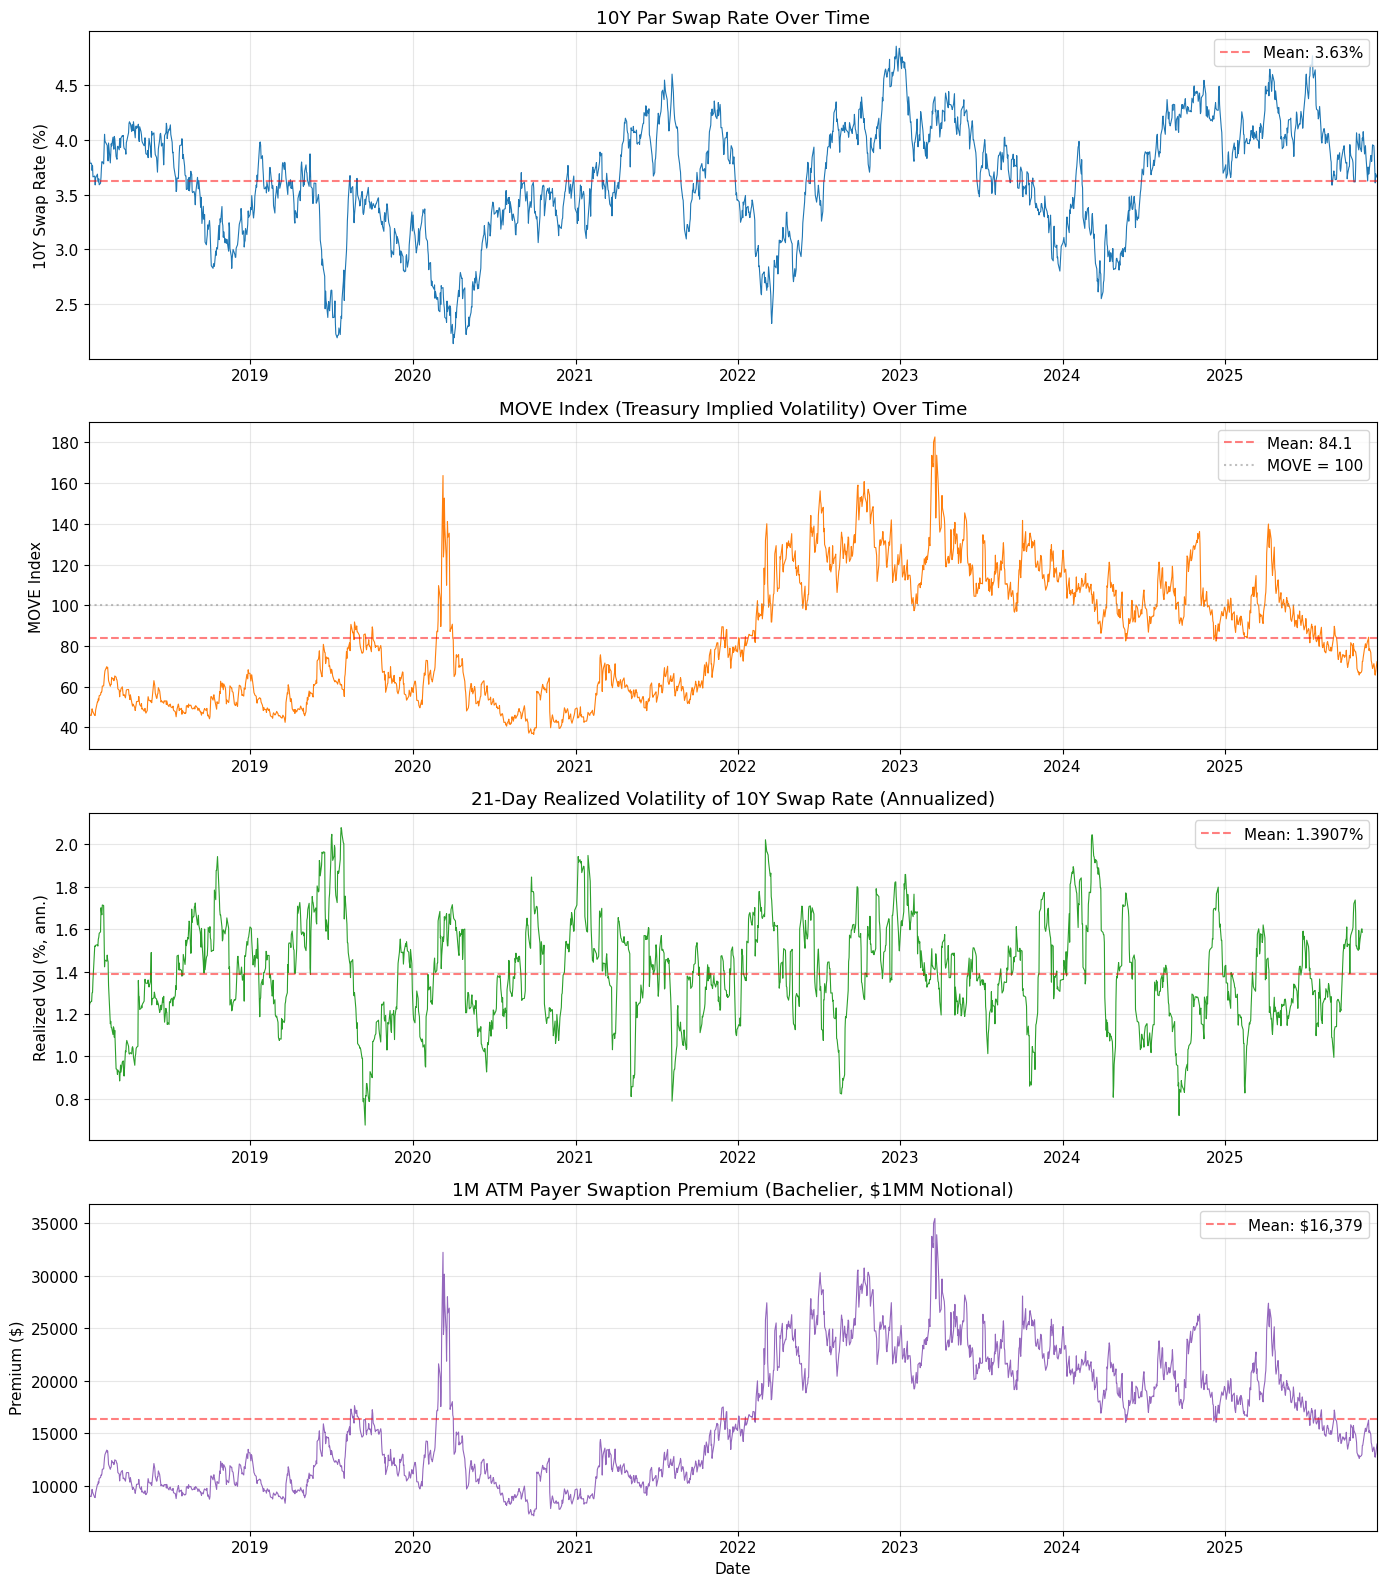

✓ Saved: outputs/plots/time_series_plots.png


In [34]:
# =============================================================================
# C.2 TIME-SERIES PLOTS
# =============================================================================

fig, axes = plt.subplots(4, 1, figsize=(14, 16))

# Plot 1: 10Y Par Swap Rate
ax1 = axes[0]
ax1.plot(merged_df.index, merged_df['S_t_pct'], color='#1f77b4', linewidth=0.8)
ax1.set_ylabel('10Y Swap Rate (%)')
ax1.set_title('10Y Par Swap Rate Over Time')
ax1.axhline(y=merged_df['S_t_pct'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {merged_df["S_t_pct"].mean():.2f}%')
ax1.legend(loc='upper right')
ax1.set_xlim(merged_df.index.min(), merged_df.index.max())

# Plot 2: MOVE Index
ax2 = axes[1]
ax2.plot(merged_df.index, merged_df['MOVE'], color='#ff7f0e', linewidth=0.8)
ax2.set_ylabel('MOVE Index')
ax2.set_title('MOVE Index (Treasury Implied Volatility) Over Time')
ax2.axhline(y=merged_df['MOVE'].mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {merged_df["MOVE"].mean():.1f}')
ax2.axhline(y=100, color='gray', linestyle=':', alpha=0.5, label='MOVE = 100')
ax2.legend(loc='upper right')
ax2.set_xlim(merged_df.index.min(), merged_df.index.max())

# Plot 3: Realized Volatility
ax3 = axes[2]
rv_pct = merged_df['realized_vol'] * 100
ax3.plot(merged_df.index, rv_pct, color='#2ca02c', linewidth=0.8)
ax3.set_ylabel('Realized Vol (%, ann.)')
ax3.set_title('21-Day Realized Volatility of 10Y Swap Rate (Annualized)')
ax3.axhline(y=rv_pct.mean(), color='red', linestyle='--', alpha=0.5, label=f'Mean: {rv_pct.mean():.4f}%')
ax3.legend(loc='upper right')
ax3.set_xlim(merged_df.index.min(), merged_df.index.max())

# Plot 4: ATM Swaption Premium
ax4 = axes[3]
ax4.plot(merged_df.index, merged_df['V_bachelier'], color='#9467bd', linewidth=0.8)
ax4.set_ylabel('Premium ($)')
ax4.set_xlabel('Date')
ax4.set_title('1M ATM Payer Swaption Premium (Bachelier, $1MM Notional)')
ax4.axhline(y=merged_df['V_bachelier'].mean(), color='red', linestyle='--', alpha=0.5, 
            label=f'Mean: ${merged_df["V_bachelier"].mean():,.0f}')
ax4.legend(loc='upper right')
ax4.set_xlim(merged_df.index.min(), merged_df.index.max())

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/time_series_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/plots/time_series_plots.png")

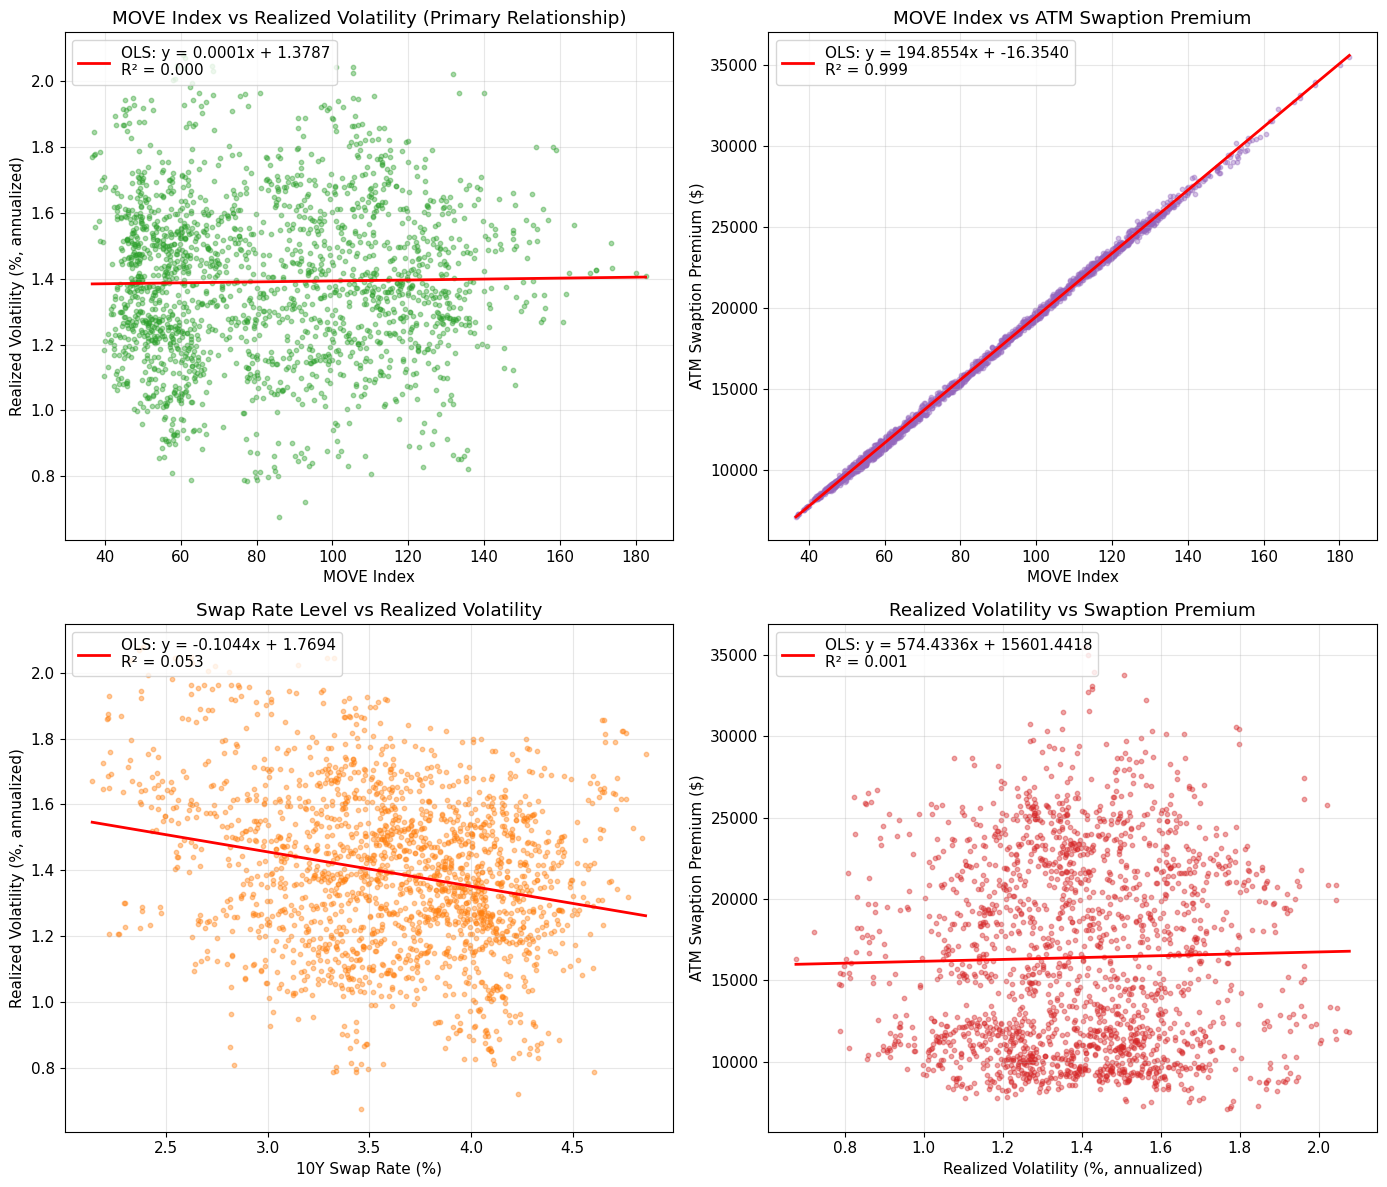

✓ Saved: outputs/plots/scatter_plots.png


In [35]:
# =============================================================================
# C.3 SCATTER PLOTS (RELATIONSHIP VISUALS)
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Helper function for scatter with regression line
def scatter_with_regression(ax, x, y, xlabel, ylabel, title, color='#1f77b4'):
    # Remove NaN
    mask = ~(np.isnan(x) | np.isnan(y))
    x_clean, y_clean = x[mask], y[mask]
    
    # Scatter
    ax.scatter(x_clean, y_clean, alpha=0.4, s=10, color=color)
    
    # Regression line
    if len(x_clean) > 10:
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_clean, y_clean)
        x_line = np.linspace(x_clean.min(), x_clean.max(), 100)
        y_line = slope * x_line + intercept
        ax.plot(x_line, y_line, 'r-', linewidth=2, 
                label=f'OLS: y = {slope:.4f}x + {intercept:.4f}\nR² = {r_value**2:.3f}')
        ax.legend(loc='upper left')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

# Plot 1: MOVE vs Realized Volatility
scatter_with_regression(
    axes[0, 0],
    merged_df['MOVE'].values,
    merged_df['realized_vol'].values * 100,
    'MOVE Index',
    'Realized Volatility (%, annualized)',
    'MOVE Index vs Realized Volatility (Primary Relationship)',
    color='#2ca02c'
)

# Plot 2: MOVE vs Swaption Premium
scatter_with_regression(
    axes[0, 1],
    merged_df['MOVE'].values,
    merged_df['V_bachelier'].values,
    'MOVE Index',
    'ATM Swaption Premium ($)',
    'MOVE Index vs ATM Swaption Premium',
    color='#9467bd'
)

# Plot 3: Swap Rate Level vs Realized Volatility
scatter_with_regression(
    axes[1, 0],
    merged_df['S_t_pct'].values,
    merged_df['realized_vol'].values * 100,
    '10Y Swap Rate (%)',
    'Realized Volatility (%, annualized)',
    'Swap Rate Level vs Realized Volatility',
    color='#ff7f0e'
)

# Plot 4: Realized Volatility vs Swaption Premium
scatter_with_regression(
    axes[1, 1],
    merged_df['realized_vol'].values * 100,
    merged_df['V_bachelier'].values,
    'Realized Volatility (%, annualized)',
    'ATM Swaption Premium ($)',
    'Realized Volatility vs Swaption Premium',
    color='#d62728'
)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/scatter_plots.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {OUTPUT_DIR}/plots/scatter_plots.png")

CORRELATION ANALYSIS

1. PEARSON CORRELATION (linear relationships):
                   S_t     MOVE  sigma_N  V_bachelier  realized_vol       A_t
S_t           1.000000 0.253000 0.253000     0.235000     -0.229000 -0.516000
MOVE          0.253000 1.000000 1.000000     0.999000      0.018000  0.026000
sigma_N       0.253000 1.000000 1.000000     0.999000      0.018000  0.026000
V_bachelier   0.235000 0.999000 0.999000     1.000000      0.023000  0.058000
realized_vol -0.229000 0.018000 0.018000     0.023000      1.000000  0.142000
A_t          -0.516000 0.026000 0.026000     0.058000      0.142000  1.000000

2. SPEARMAN CORRELATION (monotonic relationships, robust to outliers):
                   S_t      MOVE   sigma_N  V_bachelier  realized_vol  \
S_t           1.000000  0.269000  0.269000     0.248000     -0.193000   
MOVE          0.269000  1.000000  1.000000     0.999000      0.016000   
sigma_N       0.269000  1.000000  1.000000     0.999000      0.016000   
V_bachelier   0.24800

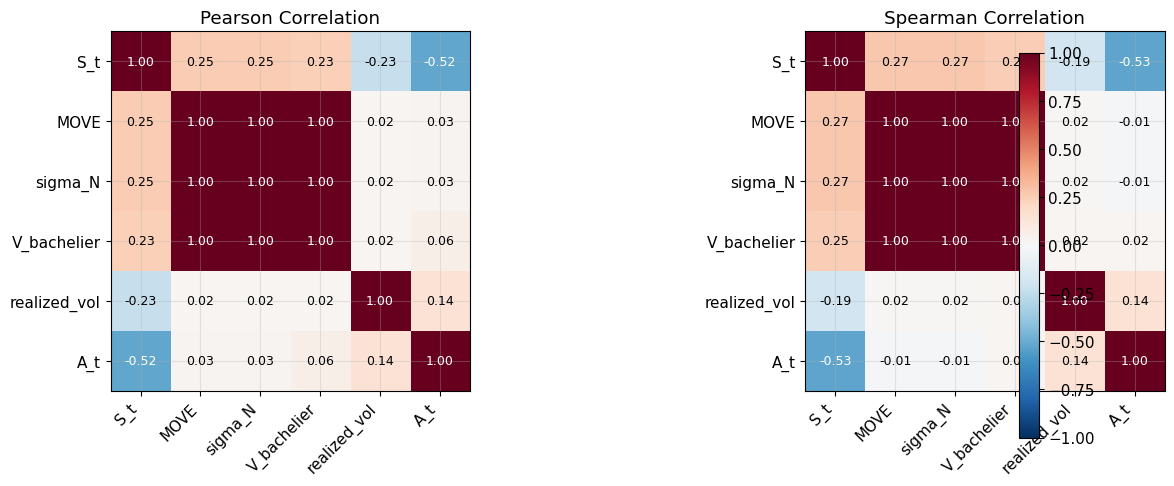


KEY CORRELATION INSIGHTS:

1. MOVE ↔ Realized Vol:
   Pearson r = 0.018, Spearman ρ = 0.016
   → Weak positive correlation

2. MOVE ↔ Swaption Premium:
   Pearson r = 0.999
   → Expected to be high (MOVE directly enters Bachelier formula via σ_N)

3. Swap Rate ↔ Realized Vol:
   Pearson r = -0.229
   → Rate level does not strongly predict volatility

✓ Saved: outputs/plots/correlation_matrix.png


In [36]:
# =============================================================================
# C.4 CORRELATION ANALYSIS
# =============================================================================

# Select columns for correlation
corr_cols = ['S_t', 'MOVE', 'sigma_N', 'V_bachelier', 'realized_vol', 'A_t']
corr_data = merged_df[corr_cols].dropna()

# Pearson correlation
pearson_corr = corr_data.corr(method='pearson')

# Spearman correlation (rank-based, robust to outliers)
spearman_corr = corr_data.corr(method='spearman')

print("=" * 70)
print("CORRELATION ANALYSIS")
print("=" * 70)

print("\n1. PEARSON CORRELATION (linear relationships):")
print(pearson_corr.round(3))

print("\n2. SPEARMAN CORRELATION (monotonic relationships, robust to outliers):")
print(spearman_corr.round(3))

# Visualize correlations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Function to plot correlation heatmap
def plot_corr_heatmap(ax, corr_matrix, title):
    im = ax.imshow(corr_matrix.values, cmap='RdBu_r', vmin=-1, vmax=1)
    
    # Add text annotations
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                          ha='center', va='center', fontsize=9,
                          color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black')
    
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    ax.set_title(title)
    return im

im1 = plot_corr_heatmap(axes[0], pearson_corr, 'Pearson Correlation')
im2 = plot_corr_heatmap(axes[1], spearman_corr, 'Spearman Correlation')

# Add colorbar
fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.02, pad=0.04)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

# Key correlation insights
print("\n" + "=" * 70)
print("KEY CORRELATION INSIGHTS:")
print("=" * 70)
r_move_rv = pearson_corr.loc['MOVE', 'realized_vol']
rho_move_rv = spearman_corr.loc['MOVE', 'realized_vol']
print(f"\n1. MOVE ↔ Realized Vol:")
print(f"   Pearson r = {r_move_rv:.3f}, Spearman ρ = {rho_move_rv:.3f}")
print(f"   → {'Strong' if abs(r_move_rv) > 0.5 else 'Moderate' if abs(r_move_rv) > 0.3 else 'Weak'} positive correlation")

r_move_v = pearson_corr.loc['MOVE', 'V_bachelier']
print(f"\n2. MOVE ↔ Swaption Premium:")
print(f"   Pearson r = {r_move_v:.3f}")
print(f"   → Expected to be high (MOVE directly enters Bachelier formula via σ_N)")

r_s_rv = pearson_corr.loc['S_t', 'realized_vol']
print(f"\n3. Swap Rate ↔ Realized Vol:")
print(f"   Pearson r = {r_s_rv:.3f}")
print(f"   → Rate level {'does' if abs(r_s_rv) > 0.3 else 'does not'} strongly predict volatility")

print(f"\n✓ Saved: {OUTPUT_DIR}/plots/correlation_matrix.png")

---
# Section D: Outliers & Transforms

1. Detect outliers using IQR and robust z-score (MAD)
2. Compare: baseline vs winsorized vs robust regression
3. Test log transformations

OUTLIER DETECTION

MOVE:
  IQR method: 0 outliers (0.00%)
    Bounds: [-21.287497, 187.452494]
  MAD method: 0 outliers (0.00%)

realized_vol:
  IQR method: 8 outliers (0.41%)
    Bounds: [0.007381, 0.020423]
  MAD method: 0 outliers (0.00%)

S_t:
  IQR method: 3 outliers (0.15%)
    Bounds: [0.021931, 0.051374]
  MAD method: 0 outliers (0.00%)

    Variable    N  Outliers (IQR) Pct (IQR)  Outliers (MAD) Pct (MAD)  IQR Lower  IQR Upper
        MOVE 1974               0     0.00%               0     0.00% -21.287497 187.452494
realized_vol 1953               8     0.41%               0     0.00%   0.007381   0.020423
         S_t 1974               3     0.15%               0     0.00%   0.021931   0.051374


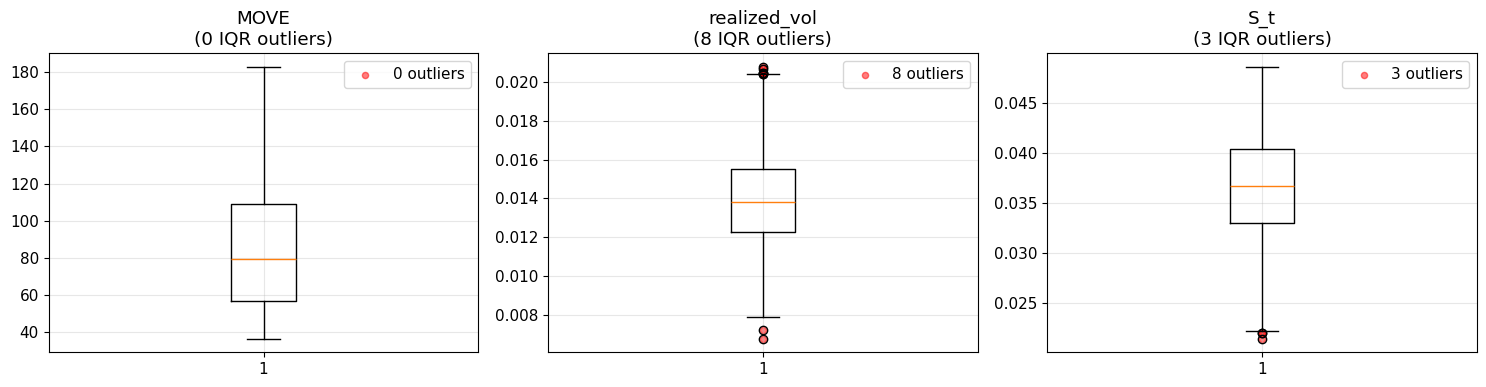


✓ Saved: outputs/plots/outlier_detection.png


In [37]:
# =============================================================================
# D.1 OUTLIER DETECTION
# =============================================================================

def detect_outliers_iqr(series, k=1.5):
    """
    Detect outliers using IQR method.
    Outliers are values below Q1 - k*IQR or above Q3 + k*IQR.
    """
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    outliers = (series < lower) | (series > upper)
    return outliers, lower, upper


def detect_outliers_mad(series, threshold=3.5):
    """
    Detect outliers using robust z-score (Median Absolute Deviation).
    More robust than standard z-score.
    """
    median = series.median()
    mad = np.abs(series - median).median()
    # Modified z-score
    modified_z = 0.6745 * (series - median) / (mad + 1e-10)
    outliers = np.abs(modified_z) > threshold
    return outliers, modified_z


print("=" * 70)
print("OUTLIER DETECTION")
print("=" * 70)

# Analyze key variables
outlier_vars = ['MOVE', 'realized_vol', 'S_t']

outlier_summary = []

for var in outlier_vars:
    if var not in merged_df.columns:
        continue
    
    series = merged_df[var].dropna()
    
    # IQR method
    outliers_iqr, lower, upper = detect_outliers_iqr(series)
    n_iqr = outliers_iqr.sum()
    
    # MAD method
    outliers_mad, z_scores = detect_outliers_mad(series)
    n_mad = outliers_mad.sum()
    
    outlier_summary.append({
        'Variable': var,
        'N': len(series),
        'Outliers (IQR)': n_iqr,
        'Pct (IQR)': f'{100*n_iqr/len(series):.2f}%',
        'Outliers (MAD)': n_mad,
        'Pct (MAD)': f'{100*n_mad/len(series):.2f}%',
        'IQR Lower': lower,
        'IQR Upper': upper
    })
    
    print(f"\n{var}:")
    print(f"  IQR method: {n_iqr} outliers ({100*n_iqr/len(series):.2f}%)")
    print(f"    Bounds: [{lower:.6f}, {upper:.6f}]")
    print(f"  MAD method: {n_mad} outliers ({100*n_mad/len(series):.2f}%)")

outlier_df = pd.DataFrame(outlier_summary)
print("\n" + "=" * 70)
print(outlier_df.to_string(index=False))

# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, var in enumerate(outlier_vars):
    if var not in merged_df.columns:
        continue
    
    series = merged_df[var].dropna()
    outliers_iqr, lower, upper = detect_outliers_iqr(series)
    
    ax = axes[i]
    ax.boxplot(series.values, vert=True)
    ax.scatter(np.ones(outliers_iqr.sum()), series[outliers_iqr], 
               color='red', alpha=0.5, s=20, label=f'{outliers_iqr.sum()} outliers')
    ax.set_title(f'{var}\n({outliers_iqr.sum()} IQR outliers)')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/outlier_detection.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR}/plots/outlier_detection.png")

CREATING TRANSFORMED VARIABLES

1. WINSORIZATION (1%/99%):
   MOVE: [36.6, 182.6] → [41.5, 153.9]
   realized_vol: clipped extreme values

2. LOG TRANSFORMATIONS:
   log(MOVE) range: [3.601, 5.208]
   log(realized_vol) range: [-4.996, -3.874]

3. ADDITIONAL FEATURES:
   delta_MOVE: daily change in MOVE
   MOVE_21d_mean: 21-day rolling mean (past only)
   MOVE_21d_std: 21-day rolling std (past only)


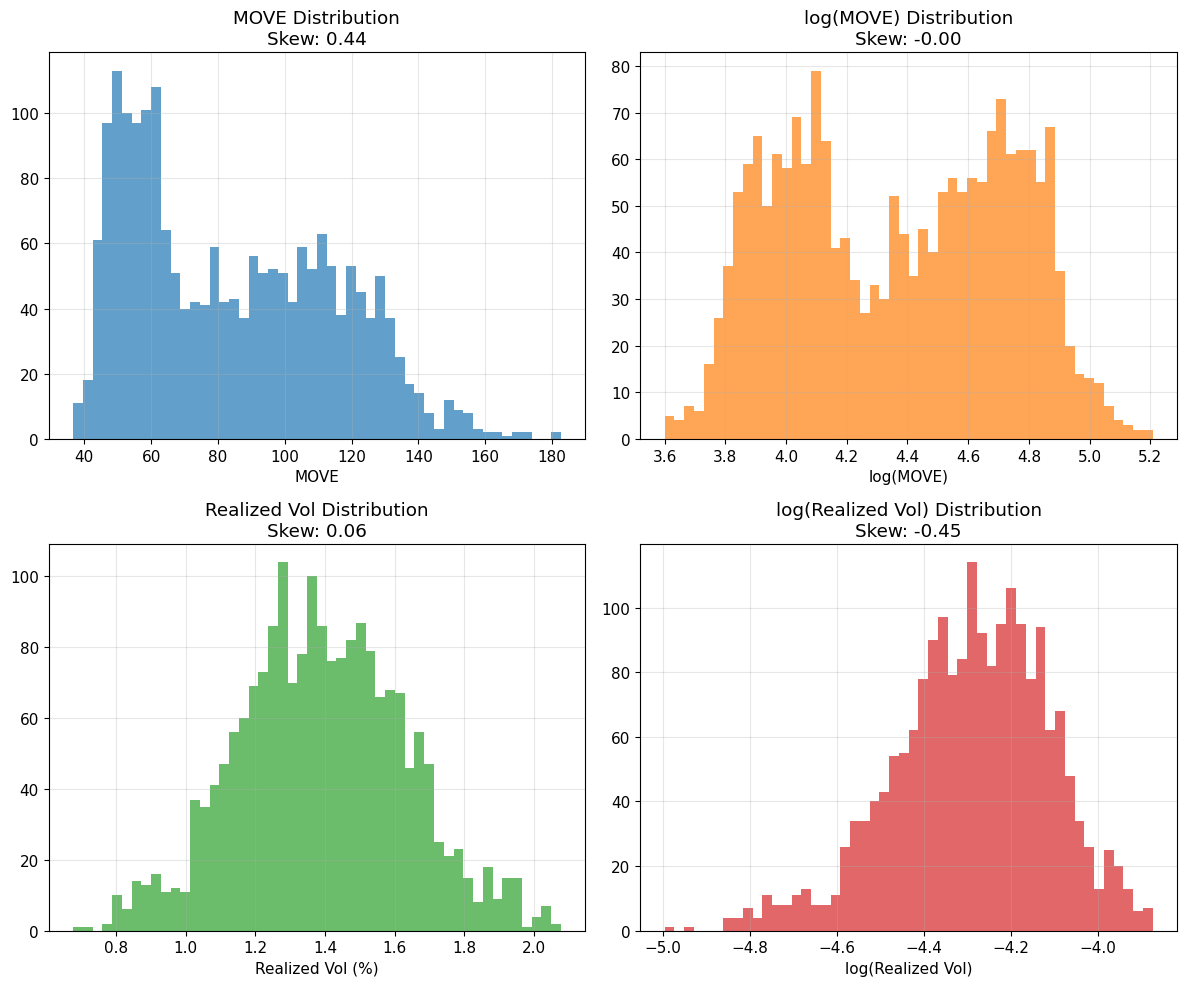


TRANSFORMATION DECISIONS:

1. MOVE: Keep in levels for interpretability. Log transform slightly reduces 
   skewness but MOVE is already reasonably symmetric.

2. Realized Vol: Consider log transform due to right skew and positive-only 
   nature. Will test both in modeling.

3. Winsorization: Will compare baseline vs winsorized (1%/99%) in robustness 
   checks to see if extreme values drive results.

4. Feature engineering: Added rolling stats computed using ONLY past data 
   to avoid look-ahead bias.

✓ Saved: outputs/plots/transformations.png


In [38]:
# =============================================================================
# D.2 OUTLIER HANDLING & TRANSFORMATIONS
# =============================================================================

def winsorize_series(series, lower_pct=1, upper_pct=99):
    """
    Winsorize a series by capping at percentiles.
    """
    lower_bound = np.percentile(series.dropna(), lower_pct)
    upper_bound = np.percentile(series.dropna(), upper_pct)
    return series.clip(lower=lower_bound, upper=upper_bound)


print("=" * 70)
print("CREATING TRANSFORMED VARIABLES")
print("=" * 70)

# 1. Winsorized versions (1%/99%)
merged_df['MOVE_winsor'] = winsorize_series(merged_df['MOVE'], 1, 99)
merged_df['realized_vol_winsor'] = winsorize_series(merged_df['realized_vol'], 1, 99)

print("\n1. WINSORIZATION (1%/99%):")
print(f"   MOVE: [{merged_df['MOVE'].min():.1f}, {merged_df['MOVE'].max():.1f}] → "
      f"[{merged_df['MOVE_winsor'].min():.1f}, {merged_df['MOVE_winsor'].max():.1f}]")
print(f"   realized_vol: clipped extreme values")

# 2. Log transformations
# Add small epsilon to avoid log(0)
eps = 1e-10
merged_df['log_MOVE'] = np.log(merged_df['MOVE'] + eps)
merged_df['log_realized_vol'] = np.log(merged_df['realized_vol'] + eps)

print("\n2. LOG TRANSFORMATIONS:")
print(f"   log(MOVE) range: [{merged_df['log_MOVE'].min():.3f}, {merged_df['log_MOVE'].max():.3f}]")
print(f"   log(realized_vol) range: [{merged_df['log_realized_vol'].min():.3f}, {merged_df['log_realized_vol'].max():.3f}]")

# 3. Additional features for modeling
# Daily change in MOVE
merged_df['delta_MOVE'] = merged_df['MOVE'].diff()

# Rolling statistics (21-day window, using ONLY past data)
merged_df['MOVE_21d_mean'] = merged_df['MOVE'].rolling(window=21, min_periods=10).mean()
merged_df['MOVE_21d_std'] = merged_df['MOVE'].rolling(window=21, min_periods=10).std()

print("\n3. ADDITIONAL FEATURES:")
print(f"   delta_MOVE: daily change in MOVE")
print(f"   MOVE_21d_mean: 21-day rolling mean (past only)")
print(f"   MOVE_21d_std: 21-day rolling std (past only)")

# Visualize transformations
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# MOVE: original vs log
ax1 = axes[0, 0]
ax1.hist(merged_df['MOVE'].dropna(), bins=50, alpha=0.7, color='#1f77b4')
ax1.set_xlabel('MOVE')
ax1.set_title(f'MOVE Distribution\nSkew: {merged_df["MOVE"].skew():.2f}')

ax2 = axes[0, 1]
ax2.hist(merged_df['log_MOVE'].dropna(), bins=50, alpha=0.7, color='#ff7f0e')
ax2.set_xlabel('log(MOVE)')
ax2.set_title(f'log(MOVE) Distribution\nSkew: {merged_df["log_MOVE"].skew():.2f}')

# Realized vol: original vs log
ax3 = axes[1, 0]
ax3.hist(merged_df['realized_vol'].dropna()*100, bins=50, alpha=0.7, color='#2ca02c')
ax3.set_xlabel('Realized Vol (%)')
ax3.set_title(f'Realized Vol Distribution\nSkew: {merged_df["realized_vol"].skew():.2f}')

ax4 = axes[1, 1]
ax4.hist(merged_df['log_realized_vol'].dropna(), bins=50, alpha=0.7, color='#d62728')
ax4.set_xlabel('log(Realized Vol)')
ax4.set_title(f'log(Realized Vol) Distribution\nSkew: {merged_df["log_realized_vol"].skew():.2f}')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/transformations.png', dpi=150, bbox_inches='tight')
plt.show()

# Transformation decision
print("\n" + "=" * 70)
print("TRANSFORMATION DECISIONS:")
print("=" * 70)
print("""
1. MOVE: Keep in levels for interpretability. Log transform slightly reduces 
   skewness but MOVE is already reasonably symmetric.

2. Realized Vol: Consider log transform due to right skew and positive-only 
   nature. Will test both in modeling.

3. Winsorization: Will compare baseline vs winsorized (1%/99%) in robustness 
   checks to see if extreme values drive results.

4. Feature engineering: Added rolling stats computed using ONLY past data 
   to avoid look-ahead bias.
""")

print(f"✓ Saved: {OUTPUT_DIR}/plots/transformations.png")

---
# Section E: Modeling as ML (Time-Series Safe)

## Key Principles:
1. **No look-ahead bias**: Features at time t use only information available at t
2. **Time-series splits**: No random shuffling, chronological order preserved
3. **HAC/Newey-West standard errors**: Required due to overlapping 21-day target windows
4. **Naive benchmark**: Model must beat rolling mean baseline
5. **Interpretability**: Focus on OLS coefficients with economic meaning

## Why HAC Standard Errors?
The 21-day forward realized vol target creates **overlapping observations**:
- Consecutive observations share 20 out of 21 returns
- This causes strong positive autocorrelation in residuals
- Standard OLS SEs are **invalid** (too small)
- HAC (lag ≈ 21 days) provides robust inference

## Feature Sets:
- **Baseline (X1)**: MOVE_t only
- **Extended**: S_t, A_t, ΔMOVE_t, rolling MOVE stats, lagged realized vol

PREPARING MODELING DATASET

⚠️ OVERLAPPING OBSERVATIONS WARNING:
   The 21-day forward realized vol target creates overlapping windows.
   - NO random shuffling (would cause leakage)
   - Chronological train/val/test split enforced
   - HAC/Newey-West SEs with lag=21 used for inference

1. Dataset Preparation:
   Original rows: 1974
   After dropping NaN: 1932
   Dropped: 42 rows

2. Leakage Check:
   Target (realized_vol_t) uses changes from t+1 to t+21
   All features use information available at time t
   Last date in modeling set: 2025-11-05
   (≈21 trading days before end of raw data)

3. Time-Series Split (CHRONOLOGICAL - NO SHUFFLE):
   Train:      1352 obs (2018-02-02 to 2023-07-11)
   Validation: 289 obs (2023-07-12 to 2024-09-04)
   Test:       291 obs (2024-09-05 to 2025-11-05)

4. Feature Dimensions:
   Baseline: 1 features ['MOVE']
   Extended: 7 features


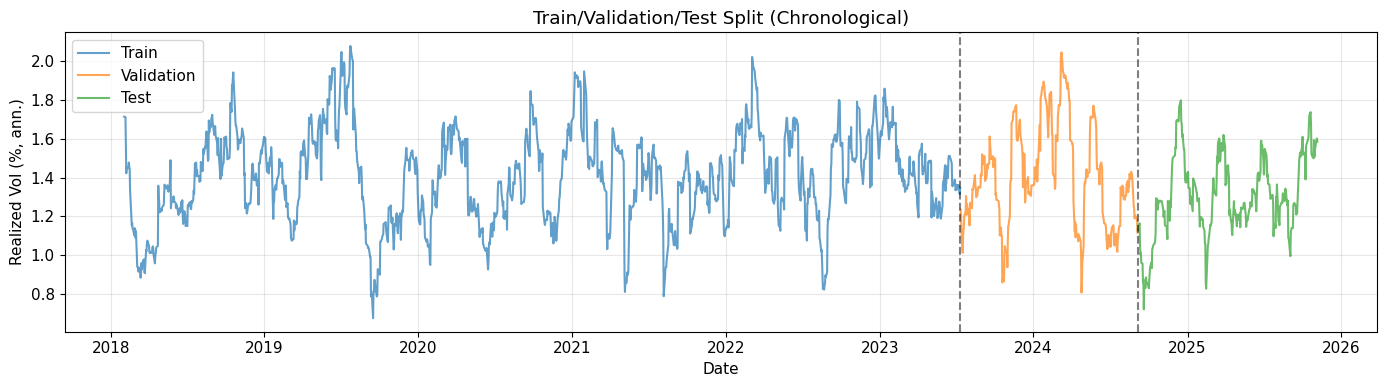


✓ Saved: outputs/plots/train_val_test_split.png


In [39]:
# =============================================================================
# E.1 PREPARE MODELING DATASET (TIME-SERIES SAFE)
# =============================================================================

print("=" * 70)
print("PREPARING MODELING DATASET")
print("=" * 70)

# =============================================================================
# CRITICAL: TIME-SERIES VALIDATION WITH OVERLAPPING TARGETS
# =============================================================================
# The 21-day forward realized volatility creates OVERLAPPING observations:
#   - Obs t uses returns from t+1 to t+21
#   - Obs t+1 uses returns from t+2 to t+22
#   - 20 out of 21 days overlap!
#
# This has two implications:
# 1. CHRONOLOGICAL SPLIT REQUIRED: Random shuffle would leak future info
# 2. HAC STANDARD ERRORS REQUIRED: Residuals are autocorrelated
# =============================================================================

print("""
⚠️ OVERLAPPING OBSERVATIONS WARNING:
   The 21-day forward realized vol target creates overlapping windows.
   - NO random shuffling (would cause leakage)
   - Chronological train/val/test split enforced
   - HAC/Newey-West SEs with lag=21 used for inference
""")

# Define features and target
TARGET = 'realized_vol'
TARGET_WINSOR = 'realized_vol_winsor'
TARGET_LOG = 'log_realized_vol'

# Feature sets
FEATURES_BASELINE = ['MOVE']
FEATURES_EXTENDED = ['MOVE', 'S_t', 'A_t', 'delta_MOVE', 'MOVE_21d_mean', 'MOVE_21d_std', 'realized_vol_lag21']

# Create modeling dataframe (drop rows with NaN target or features)
model_cols = [TARGET, TARGET_WINSOR, TARGET_LOG] + FEATURES_EXTENDED
model_df = merged_df[model_cols].copy()

# Drop NaN (target will be NaN for last 21 days, features may have NaN for early periods)
n_before = len(model_df)
model_df = model_df.dropna()
n_after = len(model_df)

print(f"1. Dataset Preparation:")
print(f"   Original rows: {n_before}")
print(f"   After dropping NaN: {n_after}")
print(f"   Dropped: {n_before - n_after} rows")

# Verify no look-ahead bias
print(f"\n2. Leakage Check:")
print(f"   Target (realized_vol_t) uses changes from t+1 to t+21")
print(f"   All features use information available at time t")
print(f"   Last date in modeling set: {model_df.index.max().date()}")
print(f"   (≈21 trading days before end of raw data)")

# Time-series split: 70% Train, 15% Validation, 15% Test (CHRONOLOGICAL, NO SHUFFLE)
n_train = int(0.70 * len(model_df))
n_val = int(0.15 * len(model_df))
n_test = len(model_df) - n_train - n_val

train_df = model_df.iloc[:n_train]
val_df = model_df.iloc[n_train:n_train + n_val]
test_df = model_df.iloc[n_train + n_val:]

print(f"\n3. Time-Series Split (CHRONOLOGICAL - NO SHUFFLE):")
print(f"   Train:      {n_train} obs ({train_df.index.min().date()} to {train_df.index.max().date()})")
print(f"   Validation: {n_val} obs ({val_df.index.min().date()} to {val_df.index.max().date()})")
print(f"   Test:       {n_test} obs ({test_df.index.min().date()} to {test_df.index.max().date()})")

# Create X, y arrays
X_train_base = train_df[FEATURES_BASELINE].values
X_val_base = val_df[FEATURES_BASELINE].values
X_test_base = test_df[FEATURES_BASELINE].values

X_train_ext = train_df[FEATURES_EXTENDED].values
X_val_ext = val_df[FEATURES_EXTENDED].values
X_test_ext = test_df[FEATURES_EXTENDED].values

y_train = train_df[TARGET].values
y_val = val_df[TARGET].values
y_test = test_df[TARGET].values

print(f"\n4. Feature Dimensions:")
print(f"   Baseline: {X_train_base.shape[1]} features {FEATURES_BASELINE}")
print(f"   Extended: {X_train_ext.shape[1]} features")

# Visualize the split
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train_df.index, train_df[TARGET]*100, label='Train', alpha=0.7)
ax.plot(val_df.index, val_df[TARGET]*100, label='Validation', alpha=0.7)
ax.plot(test_df.index, test_df[TARGET]*100, label='Test', alpha=0.7)
ax.axvline(x=train_df.index.max(), color='black', linestyle='--', alpha=0.5)
ax.axvline(x=val_df.index.max(), color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Realized Vol (%, ann.)')
ax.set_title('Train/Validation/Test Split (Chronological)')
ax.legend()
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/train_val_test_split.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {OUTPUT_DIR}/plots/train_val_test_split.png")

In [40]:
# =============================================================================
# E.2 NAIVE BENCHMARK
# =============================================================================

print("=" * 70)
print("NAIVE BENCHMARK: Rolling Mean of Past Realized Vol")
print("=" * 70)

def naive_forecast(realized_vol_series, window=63):
    """
    Naive forecast: predict realized_vol_t = rolling mean of past {window} days.
    This uses ONLY past information (no leakage).
    """
    return realized_vol_series.rolling(window=window, min_periods=21).mean().shift(1)


# Compute naive predictions
model_df['naive_pred'] = naive_forecast(model_df[TARGET], window=63)

# Get naive predictions for val and test
naive_val = model_df.loc[val_df.index, 'naive_pred'].values
naive_test = model_df.loc[test_df.index, 'naive_pred'].values

# Compute metrics for naive benchmark
def compute_metrics(y_true, y_pred, name='Model'):
    """Compute MAE, RMSE, R² for predictions."""
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true_clean = y_true[mask]
    y_pred_clean = y_pred[mask]
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    r2 = r2_score(y_true_clean, y_pred_clean)
    
    return {'Model': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2, 'N': len(y_true_clean)}


naive_metrics_val = compute_metrics(y_val, naive_val, 'Naive (63d mean) - Val')
naive_metrics_test = compute_metrics(y_test, naive_test, 'Naive (63d mean) - Test')

print(f"\nNaive Benchmark Performance:")
print(f"\nValidation Set:")
print(f"  MAE:  {naive_metrics_val['MAE']*100:.6f}% (annualized)")
print(f"  RMSE: {naive_metrics_val['RMSE']*100:.6f}%")
print(f"  R²:   {naive_metrics_val['R²']:.4f}")

print(f"\nTest Set:")
print(f"  MAE:  {naive_metrics_test['MAE']*100:.6f}%")
print(f"  RMSE: {naive_metrics_test['RMSE']*100:.6f}%")
print(f"  R²:   {naive_metrics_test['R²']:.4f}")

print(f"\n→ Models must beat these metrics to be useful")

NAIVE BENCHMARK: Rolling Mean of Past Realized Vol

Naive Benchmark Performance:

Validation Set:
  MAE:  0.190258% (annualized)
  RMSE: 0.245814%
  R²:   0.1199

Test Set:
  MAE:  0.165459%
  RMSE: 0.210503%
  R²:   -0.0436

→ Models must beat these metrics to be useful


In [41]:
# =============================================================================
# E.3 OLS REGRESSION - BASELINE MODEL (MOVE only) with HAC STANDARD ERRORS
# =============================================================================

print("=" * 70)
print("MODEL 1: OLS REGRESSION - BASELINE (MOVE only)")
print("=" * 70)

# Prepare data with constant for statsmodels
X_train_sm = sm.add_constant(train_df[FEATURES_BASELINE])
X_val_sm = sm.add_constant(val_df[FEATURES_BASELINE])
X_test_sm = sm.add_constant(test_df[FEATURES_BASELINE])

# =============================================================================
# IMPORTANT: Using HAC/Newey-West Standard Errors
# =============================================================================
# The 21-day forward realized volatility target creates OVERLAPPING observations.
# Consecutive residuals share 20 out of 21 days of returns, causing strong 
# autocorrelation in residuals. HAC (Heteroskedasticity and Autocorrelation 
# Consistent) standard errors with lag ≈ 21 days are required for valid inference.
# =============================================================================

HAC_MAXLAGS = 21  # Match the target horizon

# Fit OLS with HAC/Newey-West standard errors
print(f"\n⚠️ Using HAC/Newey-West standard errors (maxlags={HAC_MAXLAGS})")
print("   Reason: 21-day forward target creates overlapping observations")
print("   and autocorrelated residuals. HAC provides robust inference.")

ols_baseline = sm.OLS(y_train, X_train_sm).fit(cov_type='HAC', cov_kwds={'maxlags': HAC_MAXLAGS})

# Print summary
print("\nOLS Summary (Baseline - MOVE only) with HAC Standard Errors:")
print(ols_baseline.summary())

# Predictions
ols_base_pred_train = ols_baseline.predict(X_train_sm)
ols_base_pred_val = ols_baseline.predict(X_val_sm)
ols_base_pred_test = ols_baseline.predict(X_test_sm)

# Metrics
ols_base_train_metrics = compute_metrics(y_train, ols_base_pred_train, 'OLS Baseline - Train')
ols_base_val_metrics = compute_metrics(y_val, ols_base_pred_val, 'OLS Baseline - Val')
ols_base_test_metrics = compute_metrics(y_test, ols_base_pred_test, 'OLS Baseline - Test')

print(f"\n" + "=" * 70)
print("BASELINE OLS PERFORMANCE (Chronological Split):")
print("=" * 70)
print(f"\n{'Set':<12} {'MAE (%)':>12} {'RMSE (%)':>12} {'R²':>10}")
print("-" * 50)
print(f"{'Train':<12} {ols_base_train_metrics['MAE']*100:>12.6f} {ols_base_train_metrics['RMSE']*100:>12.6f} {ols_base_train_metrics['R²']:>10.4f}")
print(f"{'Validation':<12} {ols_base_val_metrics['MAE']*100:>12.6f} {ols_base_val_metrics['RMSE']*100:>12.6f} {ols_base_val_metrics['R²']:>10.4f}")
print(f"{'Test':<12} {ols_base_test_metrics['MAE']*100:>12.6f} {ols_base_test_metrics['RMSE']*100:>12.6f} {ols_base_test_metrics['R²']:>10.4f}")

# Compare to naive
print(f"\n→ vs Naive Benchmark (Test):")
print(f"   MAE improvement:  {(1 - ols_base_test_metrics['MAE']/naive_metrics_test['MAE'])*100:.2f}%")
print(f"   RMSE improvement: {(1 - ols_base_test_metrics['RMSE']/naive_metrics_test['RMSE'])*100:.2f}%")

# Save OLS summary
with open(f'{OUTPUT_DIR}/tables/ols_baseline_summary.txt', 'w') as f:
    f.write("OLS Baseline with HAC/Newey-West Standard Errors (maxlags=21)\n")
    f.write("=" * 70 + "\n\n")
    f.write(str(ols_baseline.summary()))
print(f"\n✓ Saved: {OUTPUT_DIR}/tables/ols_baseline_summary.txt")

MODEL 1: OLS REGRESSION - BASELINE (MOVE only)

⚠️ Using HAC/Newey-West standard errors (maxlags=21)
   Reason: 21-day forward target creates overlapping observations
   and autocorrelated residuals. HAC provides robust inference.

OLS Summary (Baseline - MOVE only) with HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.500
Date:                Tue, 09 Dec 2025   Prob (F-statistic):              0.221
Time:                        21:35:47   Log-Likelihood:                 6246.5
No. Observations:                1352   AIC:                        -1.249e+04
Df Residuals:                    1350   BIC:                        -1.248e+04
Df Model:                           1                                      

In [42]:
# =============================================================================
# E.4 OLS REGRESSION - EXTENDED MODEL with HAC STANDARD ERRORS
# =============================================================================

print("=" * 70)
print("MODEL 2: OLS REGRESSION - EXTENDED FEATURES")
print("=" * 70)

# Prepare data with constant
X_train_ext_sm = sm.add_constant(train_df[FEATURES_EXTENDED])
X_val_ext_sm = sm.add_constant(val_df[FEATURES_EXTENDED])
X_test_ext_sm = sm.add_constant(test_df[FEATURES_EXTENDED])

# Fit OLS with HAC/Newey-West standard errors
print(f"\n⚠️ Using HAC/Newey-West standard errors (maxlags={HAC_MAXLAGS})")
ols_extended = sm.OLS(y_train, X_train_ext_sm).fit(cov_type='HAC', cov_kwds={'maxlags': HAC_MAXLAGS})

# Print summary
print("\nOLS Summary (Extended Features) with HAC Standard Errors:")
print(ols_extended.summary())

# Predictions
ols_ext_pred_train = ols_extended.predict(X_train_ext_sm)
ols_ext_pred_val = ols_extended.predict(X_val_ext_sm)
ols_ext_pred_test = ols_extended.predict(X_test_ext_sm)

# Metrics
ols_ext_train_metrics = compute_metrics(y_train, ols_ext_pred_train, 'OLS Extended - Train')
ols_ext_val_metrics = compute_metrics(y_val, ols_ext_pred_val, 'OLS Extended - Val')
ols_ext_test_metrics = compute_metrics(y_test, ols_ext_pred_test, 'OLS Extended - Test')

print(f"\n" + "=" * 70)
print("EXTENDED OLS PERFORMANCE (Chronological Split):")
print("=" * 70)
print(f"\n{'Set':<12} {'MAE (%)':>12} {'RMSE (%)':>12} {'R²':>10}")
print("-" * 50)
print(f"{'Train':<12} {ols_ext_train_metrics['MAE']*100:>12.6f} {ols_ext_train_metrics['RMSE']*100:>12.6f} {ols_ext_train_metrics['R²']:>10.4f}")
print(f"{'Validation':<12} {ols_ext_val_metrics['MAE']*100:>12.6f} {ols_ext_val_metrics['RMSE']*100:>12.6f} {ols_ext_val_metrics['R²']:>10.4f}")
print(f"{'Test':<12} {ols_ext_test_metrics['MAE']*100:>12.6f} {ols_ext_test_metrics['RMSE']*100:>12.6f} {ols_ext_test_metrics['R²']:>10.4f}")

# Compare to baseline
print(f"\n→ vs Baseline OLS (Test):")
print(f"   R² change: {ols_base_test_metrics['R²']:.4f} → {ols_ext_test_metrics['R²']:.4f}")

# Save summary
with open(f'{OUTPUT_DIR}/tables/ols_extended_summary.txt', 'w') as f:
    f.write("OLS Extended with HAC/Newey-West Standard Errors (maxlags=21)\n")
    f.write("=" * 70 + "\n\n")
    f.write(str(ols_extended.summary()))
print(f"\n✓ Saved: {OUTPUT_DIR}/tables/ols_extended_summary.txt")

MODEL 2: OLS REGRESSION - EXTENDED FEATURES

⚠️ Using HAC/Newey-West standard errors (maxlags=21)

OLS Summary (Extended Features) with HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2.535
Date:                Tue, 09 Dec 2025   Prob (F-statistic):             0.0136
Time:                        21:35:47   Log-Likelihood:                 6298.9
No. Observations:                1352   AIC:                        -1.258e+04
Df Residuals:                    1344   BIC:                        -1.254e+04
Df Model:                           7                                         
Covariance Type:                  HAC                                         
                         coef    std err          z  

OLS DIAGNOSTICS

NOTE ON OVERLAPPING OBSERVATIONS:
---------------------------------
The 21-day forward realized volatility target creates overlapping windows.
Observation t uses returns from t+1 to t+21.
Observation t+1 uses returns from t+2 to t+22.
→ 20 out of 21 returns overlap between consecutive observations!

This causes STRONG autocorrelation in residuals, making standard OLS 
standard errors invalid. HAC/Newey-West SEs (already applied) correct this.



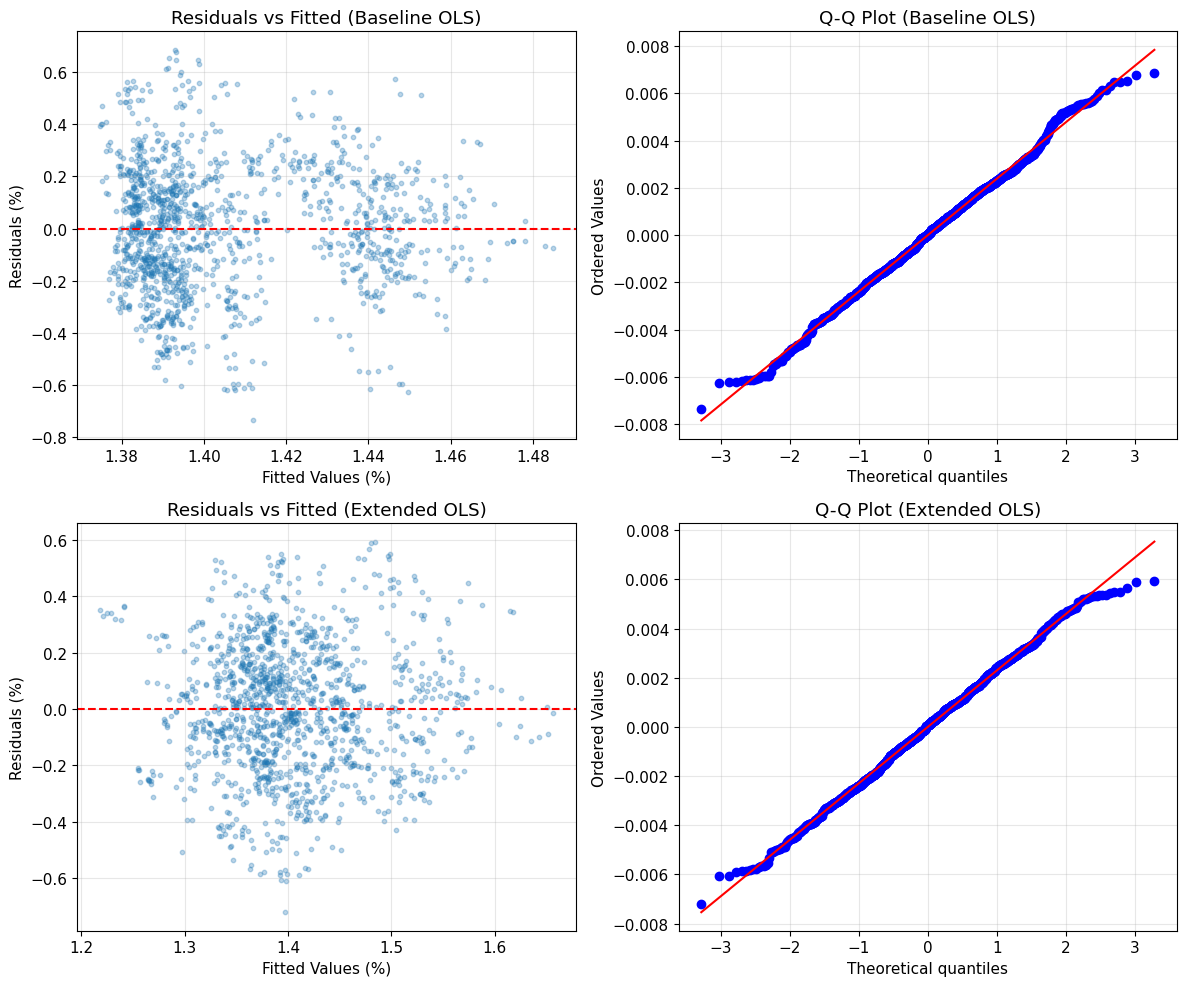


1. RESIDUAL AUTOCORRELATION CHECK:
--------------------------------------------------

Durbin-Watson Statistic (0=perfect +AC, 2=no AC, 4=perfect -AC):
  Baseline Model: DW = 0.0996
  Extended Model: DW = 0.1236

  DW << 2 confirms strong positive autocorrelation (expected with overlapping).
  → HAC standard errors (maxlags=21) address this.

2. HETEROSKEDASTICITY TEST (Breusch-Pagan):
--------------------------------------------------

Baseline Model:
  LM Statistic: 6.6133
  p-value: 0.0101
  → Heteroskedasticity detected

Extended Model:
  LM Statistic: 96.9662
  p-value: 0.0000
  → Heteroskedasticity detected

3. HAC vs STANDARD ERRORS COMPARISON:
--------------------------------------------------

Coefficients are identical; only standard errors differ.
HAC SEs are typically LARGER, giving more conservative t-stats/p-values.

Baseline Model Coefficient (MOVE):
  Coef: 0.00000755
  SE (standard): 0.00000201
  SE (HAC, lag=21): 0.00000616
  Ratio (HAC/standard): 3.06x

✓ Saved: out

In [43]:
# =============================================================================
# E.5 OLS DIAGNOSTICS & TIME-SERIES VALIDATION
# =============================================================================

print("=" * 70)
print("OLS DIAGNOSTICS")
print("=" * 70)

print("""
NOTE ON OVERLAPPING OBSERVATIONS:
---------------------------------
The 21-day forward realized volatility target creates overlapping windows.
Observation t uses returns from t+1 to t+21.
Observation t+1 uses returns from t+2 to t+22.
→ 20 out of 21 returns overlap between consecutive observations!

This causes STRONG autocorrelation in residuals, making standard OLS 
standard errors invalid. HAC/Newey-West SEs (already applied) correct this.
""")

# 1. Residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Residuals vs Fitted (Baseline)
residuals_base = y_train - ols_base_pred_train
ax1 = axes[0, 0]
ax1.scatter(ols_base_pred_train * 100, residuals_base * 100, alpha=0.3, s=10)
ax1.axhline(y=0, color='red', linestyle='--')
ax1.set_xlabel('Fitted Values (%)')
ax1.set_ylabel('Residuals (%)')
ax1.set_title('Residuals vs Fitted (Baseline OLS)')

# Q-Q plot (Baseline)
ax2 = axes[0, 1]
stats.probplot(residuals_base, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot (Baseline OLS)')

# Residuals vs Fitted (Extended)
residuals_ext = y_train - ols_ext_pred_train
ax3 = axes[1, 0]
ax3.scatter(ols_ext_pred_train * 100, residuals_ext * 100, alpha=0.3, s=10)
ax3.axhline(y=0, color='red', linestyle='--')
ax3.set_xlabel('Fitted Values (%)')
ax3.set_ylabel('Residuals (%)')
ax3.set_title('Residuals vs Fitted (Extended OLS)')

# Q-Q plot (Extended)
ax4 = axes[1, 1]
stats.probplot(residuals_ext, dist="norm", plot=ax4)
ax4.set_title('Q-Q Plot (Extended OLS)')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/plots/ols_residual_diagnostics.png', dpi=150, bbox_inches='tight')
plt.show()

# 2. Check residual autocorrelation (expected to be high due to overlapping)
print("\n1. RESIDUAL AUTOCORRELATION CHECK:")
print("-" * 50)
from statsmodels.stats.stattools import durbin_watson

dw_base = durbin_watson(residuals_base)
dw_ext = durbin_watson(residuals_ext)

print(f"\nDurbin-Watson Statistic (0=perfect +AC, 2=no AC, 4=perfect -AC):")
print(f"  Baseline Model: DW = {dw_base:.4f}")
print(f"  Extended Model: DW = {dw_ext:.4f}")
print(f"\n  DW << 2 confirms strong positive autocorrelation (expected with overlapping).")
print(f"  → HAC standard errors (maxlags={HAC_MAXLAGS}) address this.")

# 3. Breusch-Pagan test for heteroskedasticity
print("\n2. HETEROSKEDASTICITY TEST (Breusch-Pagan):")
print("-" * 50)

bp_test_base = het_breuschpagan(residuals_base, X_train_sm)
print(f"\nBaseline Model:")
print(f"  LM Statistic: {bp_test_base[0]:.4f}")
print(f"  p-value: {bp_test_base[1]:.4f}")
print(f"  → {'Heteroskedasticity detected' if bp_test_base[1] < 0.05 else 'No significant heteroskedasticity'}")

bp_test_ext = het_breuschpagan(residuals_ext, X_train_ext_sm)
print(f"\nExtended Model:")
print(f"  LM Statistic: {bp_test_ext[0]:.4f}")
print(f"  p-value: {bp_test_ext[1]:.4f}")
print(f"  → {'Heteroskedasticity detected' if bp_test_ext[1] < 0.05 else 'No significant heteroskedasticity'}")

# 4. Coefficient comparison: OLS vs HAC standard errors
print("\n3. HAC vs STANDARD ERRORS COMPARISON:")
print("-" * 50)
print("\nCoefficients are identical; only standard errors differ.")
print("HAC SEs are typically LARGER, giving more conservative t-stats/p-values.")

# Fit without HAC for comparison
ols_base_nonhac = sm.OLS(y_train, X_train_sm).fit()

print(f"\nBaseline Model Coefficient (MOVE):")
print(f"  Coef: {ols_baseline.params['MOVE']:.8f}")
print(f"  SE (standard): {ols_base_nonhac.bse['MOVE']:.8f}")
print(f"  SE (HAC, lag={HAC_MAXLAGS}): {ols_baseline.bse['MOVE']:.8f}")
print(f"  Ratio (HAC/standard): {ols_baseline.bse['MOVE']/ols_base_nonhac.bse['MOVE']:.2f}x")

print(f"\n✓ Saved: {OUTPUT_DIR}/plots/ols_residual_diagnostics.png")

In [44]:
# =============================================================================
# E.6 MULTICOLLINEARITY CHECK (VIF)
# =============================================================================

print("=" * 70)
print("MULTICOLLINEARITY CHECK (VIF - Variance Inflation Factor)")
print("=" * 70)

# Compute VIF for extended features
X_for_vif = train_df[FEATURES_EXTENDED].copy()

vif_data = []
for i, col in enumerate(X_for_vif.columns):
    vif = variance_inflation_factor(X_for_vif.values, i)
    vif_data.append({'Feature': col, 'VIF': vif})

vif_df = pd.DataFrame(vif_data)
vif_df = vif_df.sort_values('VIF', ascending=False)

print("\nVIF Values (Extended Features):")
print("-" * 40)
for _, row in vif_df.iterrows():
    status = '⚠️ HIGH' if row['VIF'] > 10 else '⚠️ MODERATE' if row['VIF'] > 5 else '✓'
    print(f"  {row['Feature']:<25}: {row['VIF']:>8.2f} {status}")

print(f"\nInterpretation:")
print(f"  VIF > 10: High multicollinearity (consider dropping)")
print(f"  VIF 5-10: Moderate (monitor)")
print(f"  VIF < 5: Acceptable")

# If high VIF, test reduced model
high_vif_features = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
if len(high_vif_features) > 0:
    print(f"\n→ High VIF features: {high_vif_features}")
    print(f"  These features may be collinear. Consider model with subset.")
else:
    print(f"\n→ No severe multicollinearity issues detected")

MULTICOLLINEARITY CHECK (VIF - Variance Inflation Factor)

VIF Values (Extended Features):
----------------------------------------
  MOVE_21d_mean            :    87.70 ⚠️ HIGH
  MOVE                     :    87.50 ⚠️ HIGH
  A_t                      :    85.31 ⚠️ HIGH
  S_t                      :    52.70 ⚠️ HIGH
  realized_vol_lag21       :    37.11 ⚠️ HIGH
  MOVE_21d_std             :     5.41 ⚠️ MODERATE
  delta_MOVE               :     1.17 ✓

Interpretation:
  VIF > 10: High multicollinearity (consider dropping)
  VIF 5-10: Moderate (monitor)
  VIF < 5: Acceptable

→ High VIF features: ['MOVE_21d_mean', 'MOVE', 'A_t', 'S_t', 'realized_vol_lag21']
  These features may be collinear. Consider model with subset.


In [45]:
# =============================================================================
# E.7 ROBUST REGRESSION (HUBER) & RANDOM FOREST
# =============================================================================

print("=" * 70)
print("ALTERNATIVE MODELS: Huber Regression & Random Forest")
print("=" * 70)

# 1. Huber Regression (robust to outliers)
print("\n1. HUBER REGRESSION (Baseline Features):")
print("-" * 50)

huber = HuberRegressor(epsilon=1.35, max_iter=1000)
huber.fit(X_train_base, y_train)

huber_pred_val = huber.predict(X_val_base)
huber_pred_test = huber.predict(X_test_base)

huber_val_metrics = compute_metrics(y_val, huber_pred_val, 'Huber - Val')
huber_test_metrics = compute_metrics(y_test, huber_pred_test, 'Huber - Test')

print(f"\nHuber Regression Coefficients:")
print(f"  Intercept: {huber.intercept_:.8f}")
for i, feat in enumerate(FEATURES_BASELINE):
    print(f"  {feat}: {huber.coef_[i]:.8f}")

print(f"\nHuber Performance (Test):")
print(f"  MAE:  {huber_test_metrics['MAE']*100:.6f}%")
print(f"  RMSE: {huber_test_metrics['RMSE']*100:.6f}%")
print(f"  R²:   {huber_test_metrics['R²']:.4f}")

# 2. Random Forest (non-linear baseline)
print("\n2. RANDOM FOREST (Extended Features):")
print("-" * 50)

rf = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_leaf=20, 
                          random_state=42, n_jobs=-1)
rf.fit(X_train_ext, y_train)

rf_pred_val = rf.predict(X_val_ext)
rf_pred_test = rf.predict(X_test_ext)

rf_val_metrics = compute_metrics(y_val, rf_pred_val, 'RF - Val')
rf_test_metrics = compute_metrics(y_test, rf_pred_test, 'RF - Test')

print(f"\nRandom Forest Feature Importance:")
importance_df = pd.DataFrame({
    'Feature': FEATURES_EXTENDED,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)
print(importance_df.to_string(index=False))

print(f"\nRandom Forest Performance (Test):")
print(f"  MAE:  {rf_test_metrics['MAE']*100:.6f}%")
print(f"  RMSE: {rf_test_metrics['RMSE']*100:.6f}%")
print(f"  R²:   {rf_test_metrics['R²']:.4f}")

# Save feature importance
importance_df.to_csv(f'{OUTPUT_DIR}/tables/rf_feature_importance.csv', index=False)
print(f"\n✓ Saved: {OUTPUT_DIR}/tables/rf_feature_importance.csv")

ALTERNATIVE MODELS: Huber Regression & Random Forest

1. HUBER REGRESSION (Baseline Features):
--------------------------------------------------

Huber Regression Coefficients:
  Intercept: 0.01338207
  MOVE: 0.00000885

Huber Performance (Test):
  MAE:  0.200693%
  RMSE: 0.241297%
  R²:   -0.3713

2. RANDOM FOREST (Extended Features):
--------------------------------------------------

Random Forest Feature Importance:
           Feature  Importance
               A_t    0.272257
               S_t    0.231143
     MOVE_21d_mean    0.222003
              MOVE    0.098008
realized_vol_lag21    0.088572
      MOVE_21d_std    0.087905
        delta_MOVE    0.000112

Random Forest Performance (Test):
  MAE:  0.210185%
  RMSE: 0.250515%
  R²:   -0.4781

✓ Saved: outputs/tables/rf_feature_importance.csv


In [46]:
# =============================================================================
# E.8 MODEL COMPARISON SUMMARY
# =============================================================================

print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

# Collect all metrics
all_metrics = [
    {'Model': 'Naive (63d mean)', 'Set': 'Val', **{k: v for k, v in naive_metrics_val.items() if k != 'Model'}},
    {'Model': 'Naive (63d mean)', 'Set': 'Test', **{k: v for k, v in naive_metrics_test.items() if k != 'Model'}},
    {'Model': 'OLS Baseline', 'Set': 'Val', **{k: v for k, v in ols_base_val_metrics.items() if k != 'Model'}},
    {'Model': 'OLS Baseline', 'Set': 'Test', **{k: v for k, v in ols_base_test_metrics.items() if k != 'Model'}},
    {'Model': 'OLS Extended', 'Set': 'Val', **{k: v for k, v in ols_ext_val_metrics.items() if k != 'Model'}},
    {'Model': 'OLS Extended', 'Set': 'Test', **{k: v for k, v in ols_ext_test_metrics.items() if k != 'Model'}},
    {'Model': 'Huber Reg', 'Set': 'Val', **{k: v for k, v in huber_val_metrics.items() if k != 'Model'}},
    {'Model': 'Huber Reg', 'Set': 'Test', **{k: v for k, v in huber_test_metrics.items() if k != 'Model'}},
    {'Model': 'Random Forest', 'Set': 'Val', **{k: v for k, v in rf_val_metrics.items() if k != 'Model'}},
    {'Model': 'Random Forest', 'Set': 'Test', **{k: v for k, v in rf_test_metrics.items() if k != 'Model'}},
]

comparison_df = pd.DataFrame(all_metrics)

# Convert to percentages for readability
comparison_df['MAE (%)'] = comparison_df['MAE'] * 100
comparison_df['RMSE (%)'] = comparison_df['RMSE'] * 100
comparison_df['R²'] = comparison_df['R²'].round(4)

# Pivot for cleaner display
print("\nValidation Set Performance:")
val_comparison = comparison_df[comparison_df['Set'] == 'Val'][['Model', 'MAE (%)', 'RMSE (%)', 'R²']]
print(val_comparison.to_string(index=False))

print("\nTest Set Performance:")
test_comparison = comparison_df[comparison_df['Set'] == 'Test'][['Model', 'MAE (%)', 'RMSE (%)', 'R²']]
print(test_comparison.to_string(index=False))

# Best model determination
test_metrics_only = comparison_df[comparison_df['Set'] == 'Test']
best_mae = test_metrics_only.loc[test_metrics_only['MAE (%)'].idxmin(), 'Model']
best_r2 = test_metrics_only.loc[test_metrics_only['R²'].idxmax(), 'Model']

print(f"\n" + "=" * 70)
print("CONCLUSIONS:")
print("=" * 70)
print(f"\n• Best MAE (Test): {best_mae}")
print(f"• Best R² (Test): {best_r2}")

# Check if we beat naive
naive_test_mae = comparison_df[(comparison_df['Model'] == 'Naive (63d mean)') & (comparison_df['Set'] == 'Test')]['MAE (%)'].values[0]
ols_base_mae = comparison_df[(comparison_df['Model'] == 'OLS Baseline') & (comparison_df['Set'] == 'Test')]['MAE (%)'].values[0]

if ols_base_mae < naive_test_mae:
    print(f"\n✓ OLS Baseline BEATS naive benchmark on MAE ({ols_base_mae:.4f}% vs {naive_test_mae:.4f}%)")
else:
    print(f"\n⚠️ OLS Baseline does NOT beat naive benchmark on MAE")
    print(f"   This may indicate MOVE is not a strong predictor of future realized vol")

# Save comparison
comparison_df[['Model', 'Set', 'MAE (%)', 'RMSE (%)', 'R²', 'N']].to_csv(
    f'{OUTPUT_DIR}/tables/model_comparison.csv', index=False
)
print(f"\n✓ Saved: {OUTPUT_DIR}/tables/model_comparison.csv")

MODEL COMPARISON SUMMARY

Validation Set Performance:
           Model  MAE (%)  RMSE (%)        R²
Naive (63d mean) 0.190258  0.245814  0.119900
    OLS Baseline 0.217083  0.265228 -0.024600
    OLS Extended 0.224503  0.276410 -0.112800
       Huber Reg 0.218531  0.266138 -0.031700
   Random Forest 0.227720  0.279879 -0.141000

Test Set Performance:
           Model  MAE (%)  RMSE (%)        R²
Naive (63d mean) 0.165459  0.210503 -0.043600
    OLS Baseline 0.198546  0.238984 -0.345200
    OLS Extended 0.180081  0.220261 -0.142700
       Huber Reg 0.200693  0.241297 -0.371300
   Random Forest 0.210185  0.250515 -0.478100

CONCLUSIONS:

• Best MAE (Test): Naive (63d mean)
• Best R² (Test): Naive (63d mean)

⚠️ OLS Baseline does NOT beat naive benchmark on MAE
   This may indicate MOVE is not a strong predictor of future realized vol

✓ Saved: outputs/tables/model_comparison.csv
